Connected to finetuning (Python 3.10.4)

In [ ]:
# Import necessary libraries and functions from helper modules
import sys
sys.path.append('../plm_circuits')

# Import utility functions
from helpers.utils import (
    clear_memory,
    load_esm,
    load_sae_prot,
    mask_flanks_segment,
    patching_metric,
    cleanup_cuda
)

# Import attribution functions
from attribution import (
    integrated_gradients_sae,
    topk_sae_err_pt
)

# Import hook classes
from hook_manager import SAEHookProt

# Additional imports
import json
from functools import partial
import torch
import numpy as np
import matplotlib.pyplot as plt
import collections

In IPython
Set autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
In IPython
Set autoreload


In [ ]:
# Setup device and load models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load ESM-2 model
esm_transformer, batch_converter, esm2_alphabet = load_esm(33, device=device)

# Load SAEs for multiple layers
main_layers = [4, 8, 12, 16, 20, 24, 28]
saes = []
for layer in main_layers:
    sae_model = load_sae_prot(ESM_DIM=1280, SAE_DIM=4096, LAYER=layer, device=device)
    saes.append(sae_model)

layer_2_saelayer = {layer: layer_idx for layer_idx, layer in enumerate(main_layers)}

Using device: cuda


In [ ]:
# Load sequence data and define protein parameters
with open('../data/full_seq_dict.json', "r") as json_file:
    seq_dict = json.load(json_file)

# Define protein-specific parameters
sse_dict = {"2B61A": [[182, 316]], "1PVGA": [[101, 202]]}
fl_dict = {"2B61A": [44, 43], "1PVGA": [65, 63]}

# Choose protein for analysis
protein = "2B61A"
seq = seq_dict[protein]
position = sse_dict[protein][0]

# Define segment boundaries
ss1_start = position[0] - 5 
ss1_end = position[0] + 5 + 1 
ss2_start = position[1] - 5 
ss2_end = position[1] + 5 + 1 

print(f"Analyzing protein: {protein}")
print(f"Sequence length: {len(seq)}")
print(f"Segment 1: {ss1_start}-{ss1_end}")
print(f"Segment 2: {ss2_start}-{ss2_end}")

Analyzing protein: 2B61A
Sequence length: 377
Segment 1: 177-188
Segment 2: 311-322


In [ ]:
# Prepare full sequence and get baseline contact predictions
full_seq_L = [(1, seq)]
_, _, batch_tokens_BL = batch_converter(full_seq_L)
batch_tokens_BL = batch_tokens_BL.to(device)
batch_mask_BL = (batch_tokens_BL != esm2_alphabet.padding_idx).to(device)

with torch.no_grad():
    full_seq_contact_LL = esm_transformer.predict_contacts(batch_tokens_BL, batch_mask_BL)[0]

# Prepare clean sequence (with optimal flanks)
clean_fl = fl_dict[protein][0]
L = len(seq)
left_start = max(0, ss1_start - clean_fl)
left_end = ss1_start
right_start = ss2_end
right_end = min(L, ss2_end + clean_fl)
unmask_left_idxs = list(range(left_start, left_end))
unmask_right_idxs = list(range(right_start, right_end))

clean_seq_L = mask_flanks_segment(seq, ss1_start, ss1_end, ss2_start, ss2_end, unmask_left_idxs, unmask_right_idxs)
_, _, clean_batch_tokens_BL = batch_converter([(1, clean_seq_L)])
clean_batch_tokens_BL = clean_batch_tokens_BL.to(device)
clean_batch_mask_BL = (clean_batch_tokens_BL != esm2_alphabet.padding_idx).to(device)

with torch.no_grad():
    clean_seq_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]

print(f"Clean flank size: {clean_fl}")
print(f"Clean sequence contact recovery: {patching_metric(clean_seq_contact_LL, full_seq_contact_LL, ss1_start, ss1_end, ss2_start, ss2_end):.4f}")

# Prepare corrupted sequence (with suboptimal flanks)
corr_fl = fl_dict[protein][1]
left_start = max(0, ss1_start - corr_fl)
left_end = ss1_start
right_start = ss2_end
right_end = min(L, ss2_end + corr_fl)
unmask_left_idxs = list(range(left_start, left_end))
unmask_right_idxs = list(range(right_start, right_end))

corr_seq_L = mask_flanks_segment(seq, ss1_start, ss1_end, ss2_start, ss2_end, unmask_left_idxs, unmask_right_idxs)
_, _, corr_batch_tokens_BL = batch_converter([(1, corr_seq_L)])
corr_batch_tokens_BL = corr_batch_tokens_BL.to(device)
corr_batch_mask_BL = (corr_batch_tokens_BL != esm2_alphabet.padding_idx).to(device)

with torch.no_grad():
    corr_seq_contact_LL = esm_transformer.predict_contacts(corr_batch_tokens_BL, corr_batch_mask_BL)[0]

print(f"Corrupted flank size: {corr_fl}")
print(f"Corrupted sequence contact recovery: {patching_metric(corr_seq_contact_LL, full_seq_contact_LL, ss1_start, ss1_end, ss2_start, ss2_end):.4f}")

# Create patching metric function
_patching_metric = partial(
    patching_metric,
    orig_contact=full_seq_contact_LL,
    ss1_start=ss1_start,
    ss1_end=ss1_end,
    ss2_start=ss2_start,
    ss2_end=ss2_end,
)

Clean flank size: 44
Clean sequence contact recovery: 0.5738
Corrupted flank size: 43
Corrupted sequence contact recovery: 0.0279


In [ ]:
# Perform causal ranking for all latent-token pairs across layers
print("Starting causal ranking with integrated gradients...")

all_effects_sae_ALS = []
all_effects_err_ABLF = []

for layer_idx in main_layers:
    print(f"\nProcessing layer {layer_idx}...")
    
    sae_model = saes[layer_2_saelayer[layer_idx]]

    # Get clean cache and error
    hook = SAEHookProt(sae=sae_model, mask_BL=clean_batch_mask_BL, cache_latents=True, layer_is_lm=False, calc_error=True, use_error=True)
    handle = esm_transformer.esm.encoder.layer[layer_idx].register_forward_hook(hook)
    with torch.no_grad():
        clean_seq_sae_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
    cleanup_cuda()
    handle.remove()
    clean_cache_LS = sae_model.feature_acts
    clean_err_cache_BLF = sae_model.error_term
    clean_contact_recovery = _patching_metric(clean_seq_sae_contact_LL)

    # Get corrupted cache and error
    hook = SAEHookProt(sae=sae_model, mask_BL=corr_batch_mask_BL, cache_latents=True, layer_is_lm=False, calc_error=True, use_error=True)
    handle = esm_transformer.esm.encoder.layer[layer_idx].register_forward_hook(hook)
    with torch.no_grad():
        corr_seq_sae_contact_LL = esm_transformer.predict_contacts(corr_batch_tokens_BL, corr_batch_mask_BL)[0]
    cleanup_cuda()
    handle.remove()
    corr_cache_LS = sae_model.feature_acts
    corr_err_cache_BLF = sae_model.error_term
    corr_contact_recovery = _patching_metric(corr_seq_sae_contact_LL)
    
    print(f"Layer {layer_idx}: Clean contact recovery: {clean_contact_recovery:.4f}, Corr contact recovery: {corr_contact_recovery:.4f}")

    # Run integrated gradients
    effect_sae_LS, effect_err_BLF = integrated_gradients_sae(
        esm_transformer,
        sae_model,
        _patching_metric,
        clean_cache_LS.to(device),
        corr_cache_LS.to(device),
        clean_err_cache_BLF.to(device),
        corr_err_cache_BLF.to(device),
        batch_tokens=clean_batch_tokens_BL,
        batch_mask=clean_batch_mask_BL,
        hook_layer=layer_idx,
    )

    all_effects_sae_ALS.append(effect_sae_LS)
    all_effects_err_ABLF.append(effect_err_BLF)

# Stack all effects
all_effects_sae_ALS = torch.stack(all_effects_sae_ALS)
all_effects_err_ABLF = torch.stack(all_effects_err_ABLF)

print(f"\nCausal ranking complete!")
print(f"SAE effects shape: {all_effects_sae_ALS.shape}")
print(f"Error effects shape: {all_effects_err_ABLF.shape}")

Starting causal ranking with integrated gradients...

Processing layer 4...
Layer 4: Clean contact recovery: 0.5738, Corr contact recovery: 0.0279
ratio: 0.0, score: 0.5737996101379395
ratio: 0.1, score: 0.601131796836853
ratio: 0.2, score: 0.4815935492515564
ratio: 0.30000000000000004, score: 0.4985087811946869
ratio: 0.4, score: 0.3368060886859894
ratio: 0.5, score: 0.2868437170982361
ratio: 0.6000000000000001, score: 0.24697260558605194
ratio: 0.7000000000000001, score: 0.12411289662122726
ratio: 0.8, score: 0.10038772225379944
ratio: 0.9, score: 0.033265773206949234

Processing layer 8...
Layer 8: Clean contact recovery: 0.5738, Corr contact recovery: 0.0279
ratio: 0.0, score: 0.5737998485565186
ratio: 0.1, score: 0.5733504891395569
ratio: 0.2, score: 0.49743935465812683
ratio: 0.30000000000000004, score: 0.4819444417953491
ratio: 0.4, score: 0.4560147225856781
ratio: 0.5, score: 0.3371899425983429
ratio: 0.6000000000000001, score: 0.24517741799354553
ratio: 0.7000000000000001, sco

In [ ]:
print("Creating layer-wise caches for performance analysis...")

clean_layer_caches = {}
corr_layer_caches = {}
clean_layer_errors = {}
corr_layer_errors = {}

for layer_idx in main_layers:
    sae_model = saes[layer_2_saelayer[layer_idx]]
    
    # Clean caches
    hook = SAEHookProt(sae=sae_model, mask_BL=clean_batch_mask_BL, cache_latents=True, 
                       layer_is_lm=False, calc_error=True, use_error=True)
    handle = esm_transformer.esm.encoder.layer[layer_idx].register_forward_hook(hook)
    with torch.no_grad():
        clean_seq_sae_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
    cleanup_cuda()
    handle.remove()
    print(f"Layer {layer_idx}, clean score: {_patching_metric(clean_seq_sae_contact_LL):.4f}")
    clean_layer_caches[layer_idx] = sae_model.feature_acts
    clean_layer_errors[layer_idx] = sae_model.error_term
    # print shapes
    print(clean_layer_caches[layer_idx].shape, clean_layer_errors[layer_idx].shape)

    # Corrupted caches
    hook = SAEHookProt(sae=sae_model, mask_BL=corr_batch_mask_BL, cache_latents=True, 
                       layer_is_lm=False, calc_error=True, use_error=True)
    handle = esm_transformer.esm.encoder.layer[layer_idx].register_forward_hook(hook)
    with torch.no_grad():
        corr_seq_sae_contact_LL = esm_transformer.predict_contacts(corr_batch_tokens_BL, corr_batch_mask_BL)[0]
    cleanup_cuda()
    handle.remove()
    print(f"Layer {layer_idx}, corr score: {_patching_metric(corr_seq_sae_contact_LL):.4f}")
    corr_layer_caches[layer_idx] = sae_model.feature_acts
    corr_layer_errors[layer_idx] = sae_model.error_term

print("Layer-wise caches created successfully!")

Creating layer-wise caches for performance analysis...
Layer 4, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 4, corr score: 0.0279
Layer 8, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 8, corr score: 0.0279
Layer 12, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 12, corr score: 0.0279
Layer 16, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 16, corr score: 0.0279
Layer 20, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 20, corr score: 0.0279
Layer 24, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 24, corr score: 0.0279
Layer 28, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 28, corr score: 0.0279
Layer-wise caches created successfully!


In [ ]:
def patch_top_k_features(target_layer, k_value, all_effects_sae_ALS, clean_layer_caches, corr_layer_caches, 
                        saes, layer_2_saelayer, esm_transformer, clean_batch_tokens_BL, clean_batch_mask_BL, 
                        clean_layer_errors, corr_layer_errors,
                        _patching_metric, device, verbose=False):
    """
    Patch the top-k most important features for a given layer and return recovery score.
    
    Args:
        target_layer: Layer to patch
        k_value: Number of top features to patch
        ... (other arguments are the data structures from above)
        verbose: Whether to print debug info
    
    Returns:
        recovery: Contact recovery score after patching
    """
    
    # Get the SAE model and effects for this layer
    sae_model = saes[layer_2_saelayer[target_layer]]
    
    # Set mean error to clean error for this layer
    sae_model.mean_error = clean_layer_errors[target_layer]
    
    target_effect_sae_LS = all_effects_sae_ALS[layer_2_saelayer[target_layer]]
    target_effect_sae_flat_LxS = target_effect_sae_LS.reshape(-1)
    
    # Get top-k indices
    top_rank_vals, top_idx = torch.topk(target_effect_sae_flat_LxS, k=k_value, largest=False, sorted=True)
    
    # Convert flattened indices back to 2D coordinates
    L, S = target_effect_sae_LS.shape
    row_indices = top_idx // S
    col_indices = top_idx % S
    
    if verbose:
        print(f"Layer {target_layer}, K={k_value}: Top effect = {top_rank_vals[0]:.6f}")
    
    # Create mask - start with all True (patch), set False for positions to not patch
    sae_mask_LS = torch.ones((L, S), dtype=torch.bool, device=device)
    
    for i in range(len(top_idx)):
        row = row_indices[i]
        col = col_indices[i]
        sae_mask_LS[row, col] = False
    
    # Set up hook for patching
    hook = SAEHookProt(
        sae=sae_model,
        mask_BL=clean_batch_mask_BL,
        patch_mask_BLS=sae_mask_LS.to(device),
        patch_value=corr_layer_caches[target_layer].to(device),
        use_mean_error=True,
    )
    handle = esm_transformer.esm.encoder.layer[target_layer].register_forward_hook(hook)
    
    # Forward pass & metric
    with torch.no_grad():
        preds_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
    recovery = _patching_metric(preds_LL)
    
    # Clean up
    handle.remove()
    cleanup_cuda()
    
    # Convert to CPU float for plotting
    if isinstance(recovery, torch.Tensor):
        recovery = recovery.cpu().item()
    
    return recovery

In [ ]:
def sweep_k_values(target_layers, k_values, all_effects_sae_ALS, clean_layer_caches, corr_layer_caches,
                  saes, layer_2_saelayer, esm_transformer, clean_batch_tokens_BL, clean_batch_mask_BL,
                  clean_layer_errors, corr_layer_errors,
                  _patching_metric, device):
    """
    Sweep through k values for multiple target layers and collect recovery scores.
    
    Returns:
        results: Dictionary with layer as key, and (k_values, recoveries) as values
    """
    
    results = {}
    
    for target_layer in target_layers:
        print(f"\nProcessing layer {target_layer}...")
        recoveries = []
        
        for k in k_values:
            recovery = patch_top_k_features(
                target_layer, k, all_effects_sae_ALS, clean_layer_caches, corr_layer_caches,
                saes, layer_2_saelayer, esm_transformer, clean_batch_tokens_BL, clean_batch_mask_BL,
                clean_layer_errors, corr_layer_errors,
                _patching_metric, device, verbose=True
            )
            recoveries.append(recovery)
            
        results[target_layer] = (k_values, recoveries)
        print(f"Layer {target_layer} complete!")
    
    return results

In [ ]:
"""
for neuron1 in l4:
    # get acts of l4 neuron1 when zero ablating or ablating with corrupted seq (prefer corrupted)
    corr_hook 

    # freeze all neuron between two layers to be clean (optional maybe)
    clean_hook 

    for neuron2 in l8:
        # record change in acts of l8 neuron2 when zero ablating or ablating with corrupted seq (prefer corrupted)
        cache_hook 

        # put changed acts of l8 neuron2 in corr_hook 
        corr_hook2 

        # record change in recovery between clean l8 and corrupted hook 2 run 
        IE (neuron1, neuron2) = delta m 
"""

'\nfor neuron1 in l4:\n    # get acts of l4 neuron1 when zero ablating or ablating with corrupted seq (prefer corrupted)\n    corr_hook \n\n    # freeze all neuron between two layers to be clean (optional maybe)\n    clean_hook \n\n    for neuron2 in l8:\n        # record change in acts of l8 neuron2 when zero ablating or ablating with corrupted seq (prefer corrupted)\n        cache_hook \n\n        # put changed acts of l8 neuron2 in corr_hook \n        corr_hook2 \n\n        # record change in recovery between clean l8 and corrupted hook 2 run \n        IE (neuron1, neuron2) = delta m \n'

In [ ]:
L, S = 379, 4096 #all_effects_sae_ALS[layer_2_saelayer[4]].shape

In [ ]:
def compute_path_patching_effect(up_layer, up_latent, down_layer, down_latent, 
                                saes, layer_2_saelayer, clean_layer_caches, corr_layer_caches, 
                                clean_layer_errors, esm_transformer, clean_batch_tokens_BL, 
                                clean_batch_mask_BL, _patching_metric, device, baseline_score):
    """
    Compute the path patching effect for a single upstream-downstream latent pair.
    
    This implements steps C and D:
    - Step C: Ablate upstream latent and record change in downstream latent
    - Step D: Set changed downstream activation and measure final metric change
    
    Args:
        up_layer, down_layer: Layer indices
        up_latent, down_latent: Latent indices  
        ... (other arguments are the shared data structures)
        baseline_score: The clean baseline score for comparison
        
    Returns:
        metric_change: Change in metric score (step D result - baseline)
    """
    
    try:
        # Get SAE models and set mean errors
        up_sae_model = saes[layer_2_saelayer[up_layer]]
        down_sae_model = saes[layer_2_saelayer[down_layer]]
        up_sae_model.mean_error = clean_layer_errors[up_layer]
        down_sae_model.mean_error = clean_layer_errors[down_layer]
        
        # Step C: Ablate upstream and record downstream change
        
        # Setup corruption hook for upstream layer
        corrupt_hook = SAEHookProt(
            sae=up_sae_model,
            mask_BL=clean_batch_mask_BL,
            patch_latent_S=up_latent,
            patch_value=corr_layer_caches[up_layer][:, up_latent].to(device),
            use_mean_error=True,
        )
        
        # Setup caching hook for downstream layer
        cache_hook = SAEHookProt(
            sae=down_sae_model,
            mask_BL=clean_batch_mask_BL,
            cache_latents=True,
            layer_is_lm=False,
            calc_error=False,
            use_error=False,
            use_mean_error=True
        )
        
        # Register both hooks
        corrupt_handle = esm_transformer.esm.encoder.layer[up_layer].register_forward_hook(corrupt_hook)
        cache_handle = esm_transformer.esm.encoder.layer[down_layer].register_forward_hook(cache_hook)
        
        # Forward pass with corruption
        with torch.no_grad():
            _ = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
        
        # Get baseline and corrupted activations for downstream latent
        # baseline_acts_down = clean_layer_caches[down_layer][:, down_latent].clone()
        corrupted_acts_down = down_sae_model.feature_acts[:, down_latent].clone()
        
        # Clean up hooks from step C
        corrupt_handle.remove()
        cache_handle.remove()
        cleanup_cuda()
        
        # Step D: Set changed downstream activation and measure metric
        
        corrupt_hook2 = SAEHookProt(
            sae=down_sae_model,
            mask_BL=clean_batch_mask_BL,
            patch_latent_S=down_latent,
            patch_value=corrupted_acts_down.to(device),
            use_mean_error=True,
        )
        
        # Register hook
        corrupt_handle2 = esm_transformer.esm.encoder.layer[down_layer].register_forward_hook(corrupt_hook2)
        
        # Forward pass with downstream corruption
        with torch.no_grad():
            final_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
        
        # Clean up hook from step D
        corrupt_handle2.remove()
        cleanup_cuda()
        
        # Calculate final metric change
        final_score = _patching_metric(final_contact_LL)
        metric_change = final_score - baseline_score
        
        # Convert to CPU float if tensor
        if isinstance(metric_change, torch.Tensor):
            metric_change = metric_change.cpu().item()
            
        return metric_change
        
    except Exception as e:
        print(f"Error processing up_layer={up_layer}, up_latent={up_latent}, down_layer={down_layer}, down_latent={down_latent}: {e}")
        return None

In [ ]:
def compute_all_path_patching_effects(layer_latent_dict, saes, layer_2_saelayer, clean_layer_caches, 
                                     corr_layer_caches, clean_layer_errors, esm_transformer, 
                                     clean_batch_tokens_BL, clean_batch_mask_BL, _patching_metric, 
                                     device, baseline_score):
    """
    Compute path patching effects for all valid layer-latent combinations.
    
    Args:
        layer_latent_dict: Dictionary with layer numbers as keys and lists of latent indices as values
        ... (other arguments are the shared data structures)
        
    Returns:
        results: List of tuples (up_layer, up_latent, down_layer, down_latent, metric_change)
                sorted by metric_change (most negative = strongest effect)
    """
    
    results = []
    total_combinations = 0
    processed_combinations = 0
    
    # Convert layer keys to integers and sort
    layers = sorted([int(layer) for layer in layer_latent_dict.keys()])
    
    # Count total combinations for progress tracking
    for i, up_layer in enumerate(layers):
        for j, down_layer in enumerate(layers):
            if up_layer < down_layer:  # Only test causal direction
                up_latents = layer_latent_dict[str(up_layer)]
                down_latents = layer_latent_dict[str(down_layer)]
                total_combinations += len(up_latents) * len(down_latents)
    
    print(f"Total combinations to test: {total_combinations}")
    
    # Test all layer pairs in causal order
    for i, up_layer in enumerate(layers):
        for j, down_layer in enumerate(layers):
            if up_layer >= down_layer:  # Skip non-causal directions
                continue
                
            print(f"\nTesting layer {up_layer} → layer {down_layer}")
            
            up_latents = layer_latent_dict[str(up_layer)]
            down_latents = layer_latent_dict[str(down_layer)]
            
            # Test all latent combinations for this layer pair
            for up_latent in up_latents:
                for down_latent in down_latents:
                    
                    metric_change = compute_path_patching_effect(
                        up_layer, up_latent, down_layer, down_latent,
                        saes, layer_2_saelayer, clean_layer_caches, corr_layer_caches,
                        clean_layer_errors, esm_transformer, clean_batch_tokens_BL,
                        clean_batch_mask_BL, _patching_metric, device, baseline_score
                    )
                    
                    if metric_change is not None:
                        results.append((up_layer, up_latent, down_layer, down_latent, metric_change))
                    
                    processed_combinations += 1
                    if processed_combinations % 100 == 0:
                        print(f"Progress: {processed_combinations}/{total_combinations} ({100*processed_combinations/total_combinations:.1f}%)")
    
    # Sort by metric change (most negative = strongest effect)
    results.sort(key=lambda x: x[4])
    
    print(f"\nCompleted! Processed {len(results)} valid combinations out of {total_combinations} total.")
    
    return results

In [ ]:
# Load the JSON file with layer-latent combinations
with open('/work/pi_jensen_umass_edu/jnainani_umass_edu/plm_circuits/results/layer_latent_dict_metx.json', 'r') as f:
    layer_latent_dict_metx = json.load(f)

print("Layer-latent combinations loaded:")
for layer in sorted(layer_latent_dict_metx.keys(), key=int):
    print(f"Layer {layer}: {len(layer_latent_dict_metx[layer])} latents")

# Get baseline score for comparison
with torch.no_grad():
    baseline_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
baseline_score = _patching_metric(baseline_contact_LL)
print(f"\nBaseline score: {baseline_score:.4f}")

Layer-latent combinations loaded:
Layer 4: 30 latents
Layer 8: 11 latents
Layer 12: 50 latents
Layer 16: 85 latents
Layer 20: 95 latents
Layer 24: 124 latents
Layer 28: 29 latents

Baseline score: 0.5738


In [ ]:
# Filter the dictionary to only keep the first three layers
filtered_layers = sorted(layer_latent_dict_metx.keys(), key=int)[:3]
layer_latent_dict = {layer: layer_latent_dict_metx[layer] for layer in filtered_layers}

print("\nFiltered layer-latent combinations:")
for layer in layer_latent_dict:
    print(f"Layer {layer}: {len(layer_latent_dict[layer])} latents")


Filtered layer-latent combinations:
Layer 4: 30 latents
Layer 8: 11 latents
Layer 12: 50 latents


In [ ]:
# Run the comprehensive path patching analysis
print("Starting comprehensive path patching analysis...")
print("This will test all causal layer-latent combinations.")

path_patching_results = compute_all_path_patching_effects(
    layer_latent_dict, saes, layer_2_saelayer, clean_layer_caches, 
    corr_layer_caches, clean_layer_errors, esm_transformer, 
    clean_batch_tokens_BL, clean_batch_mask_BL, _patching_metric, 
    device, baseline_score
)

Starting comprehensive path patching analysis...
This will test all causal layer-latent combinations.
Total combinations to test: 2380

Testing layer 4 → layer 8
Progress: 100/2380 (4.2%)
Progress: 200/2380 (8.4%)
Progress: 300/2380 (12.6%)

Testing layer 4 → layer 12
Progress: 400/2380 (16.8%)
Progress: 500/2380 (21.0%)
Progress: 600/2380 (25.2%)
Progress: 700/2380 (29.4%)
Progress: 800/2380 (33.6%)
Progress: 900/2380 (37.8%)
Progress: 1000/2380 (42.0%)
Progress: 1100/2380 (46.2%)
Progress: 1200/2380 (50.4%)
Progress: 1300/2380 (54.6%)
Progress: 1400/2380 (58.8%)
Progress: 1500/2380 (63.0%)
Progress: 1600/2380 (67.2%)
Progress: 1700/2380 (71.4%)
Progress: 1800/2380 (75.6%)

Testing layer 8 → layer 12
Progress: 1900/2380 (79.8%)
Progress: 2000/2380 (84.0%)
Progress: 2100/2380 (88.2%)
Progress: 2200/2380 (92.4%)
Progress: 2300/2380 (96.6%)

Completed! Processed 2380 valid combinations out of 2380 total.


In [ ]:
# Analyze and display results
print("\n" + "="*80)
print("PATH PATCHING RESULTS")
print("="*80)

print(f"Total edges tested: {len(path_patching_results)}")

# Show top 20 strongest effects (most negative changes)
print("\nTop 20 strongest path patching effects:")
print("Rank | Up Layer | Up Latent | Down Layer | Down Latent | Metric Change")
print("-" * 70)

for i, (up_layer, up_latent, down_layer, down_latent, metric_change) in enumerate(path_patching_results[:20]):
    print(f"{i+1:4d} | {up_layer:8d} | {up_latent:9d} | {down_layer:10d} | {down_latent:11d} | {metric_change:13.6f}")

# Show some statistics
all_changes = [result[4] for result in path_patching_results]
print(f"\nStatistics:")
print(f"Most negative change: {min(all_changes):.6f}")
print(f"Most positive change: {max(all_changes):.6f}")
print(f"Mean change: {np.mean(all_changes):.6f}")
print(f"Std change: {np.std(all_changes):.6f}")

# Show distribution by layer pairs
print(f"\nEffects by layer pairs:")
layer_pair_effects = collections.defaultdict(list)
for up_layer, up_latent, down_layer, down_latent, metric_change in path_patching_results:
    layer_pair_effects[(up_layer, down_layer)].append(metric_change)

for (up_layer, down_layer), effects in sorted(layer_pair_effects.items()):
    mean_effect = np.mean(effects)
    std_effect = np.std(effects)
    print(f"Layer {up_layer:2d} → {down_layer:2d}: {len(effects):4d} edges, mean={mean_effect:8.6f}, std={std_effect:8.6f}")


PATH PATCHING RESULTS
Total edges tested: 2380

Top 20 strongest path patching effects:
Rank | Up Layer | Up Latent | Down Layer | Down Latent | Metric Change
----------------------------------------------------------------------
   1 |        4 |      2443 |         12 |        1518 |     -0.010083
   2 |        4 |      1297 |          8 |        3921 |     -0.008903
   3 |        4 |      2443 |         12 |        3751 |     -0.008444
   4 |        4 |      2443 |         12 |        3751 |     -0.008444
   5 |        4 |      2443 |         12 |        3751 |     -0.008444
   6 |        4 |      2443 |         12 |        3751 |     -0.008444
   7 |        4 |      2443 |         12 |        3751 |     -0.008444
   8 |        4 |      2443 |         12 |        3751 |     -0.008444
   9 |        4 |      2443 |         12 |        3751 |     -0.008444
  10 |        4 |      2443 |         12 |        3751 |     -0.008444
  11 |        4 |      2443 |         12 |        3239 |   

In [ ]:
# Save results for further analysis
results_data = {
    'baseline_score': float(baseline_score),
    'path_patching_results': [
        {
            'up_layer': int(up_layer),
            'up_latent': int(up_latent), 
            'down_layer': int(down_layer),
            'down_latent': int(down_latent),
            'metric_change': float(metric_change)
        }
        for up_layer, up_latent, down_layer, down_latent, metric_change in path_patching_results
    ]
}

import os
os.makedirs('../results', exist_ok=True)

with open('../results/path_patching_results_metx_top3layers.json', 'w') as f:
    json.dump(results_data, f, indent=2)

print(f"\nResults saved to ../results/path_patching_results_metx_top3layers.json")
print(f"Total edges in results: {len(path_patching_results)}")


Results saved to ../results/path_patching_results_metx_top3layers.json
Total edges in results: 2380


In [ ]:
# Filter the dictionary to only keep the first three layers and deduplicate latents
filtered_layers = sorted(layer_latent_dict_metx.keys(), key=int)[:3]
layer_latent_dict = {}

print("\nFiltered and deduplicated layer-latent combinations:")
for layer in filtered_layers:
    # Deduplicate latents while preserving order
    unique_latents = list(dict.fromkeys(layer_latent_dict_metx[layer]))
    layer_latent_dict[layer] = unique_latents
    duplicates_removed = len(layer_latent_dict_metx[layer]) - len(unique_latents)
    print(f"Layer {layer}: {len(unique_latents)} unique latents (removed {duplicates_removed} duplicates)")

# Also check the full dataset for duplicates
print("\nDuplicate analysis across all layers:")
for layer in sorted(layer_latent_dict_metx.keys(), key=int):
    original_count = len(layer_latent_dict_metx[layer])
    unique_count = len(set(layer_latent_dict_metx[layer]))
    duplicates = original_count - unique_count
    if duplicates > 0:
        print(f"Layer {layer}: {unique_count} unique latents, {duplicates} duplicates")


Filtered and deduplicated layer-latent combinations:
Layer 4: 30 unique latents (removed 0 duplicates)
Layer 8: 10 unique latents (removed 1 duplicates)
Layer 12: 32 unique latents (removed 18 duplicates)

Duplicate analysis across all layers:
Layer 8: 10 unique latents, 1 duplicates
Layer 12: 32 unique latents, 18 duplicates
Layer 16: 53 unique latents, 32 duplicates
Layer 20: 57 unique latents, 38 duplicates
Layer 24: 76 unique latents, 48 duplicates
Layer 28: 15 unique latents, 14 duplicates


In [ ]:
# Run the comprehensive path patching analysis
print("Starting comprehensive path patching analysis...")
print("This will test all causal layer-latent combinations.")

path_patching_results = compute_all_path_patching_effects(
    layer_latent_dict, saes, layer_2_saelayer, clean_layer_caches, 
    corr_layer_caches, clean_layer_errors, esm_transformer, 
    clean_batch_tokens_BL, clean_batch_mask_BL, _patching_metric, 
    device, baseline_score
)

Starting comprehensive path patching analysis...
This will test all causal layer-latent combinations.
Total combinations to test: 1580

Testing layer 4 → layer 8
Progress: 100/1580 (6.3%)
Progress: 200/1580 (12.7%)
Progress: 300/1580 (19.0%)

Testing layer 4 → layer 12
Progress: 400/1580 (25.3%)
Progress: 500/1580 (31.6%)
Progress: 600/1580 (38.0%)
Progress: 700/1580 (44.3%)
Progress: 800/1580 (50.6%)
Progress: 900/1580 (57.0%)
Progress: 1000/1580 (63.3%)
Progress: 1100/1580 (69.6%)
Progress: 1200/1580 (75.9%)

Testing layer 8 → layer 12
Progress: 1300/1580 (82.3%)
Progress: 1400/1580 (88.6%)
Progress: 1500/1580 (94.9%)

Completed! Processed 1580 valid combinations out of 1580 total.


In [ ]:
# Analyze and display results
print("\n" + "="*80)
print("PATH PATCHING RESULTS")
print("="*80)

print(f"Total edges tested: {len(path_patching_results)}")

# Show top 20 strongest effects (most negative changes)
print("\nTop 20 strongest path patching effects:")
print("Rank | Up Layer | Up Latent | Down Layer | Down Latent | Metric Change")
print("-" * 70)

for i, (up_layer, up_latent, down_layer, down_latent, metric_change) in enumerate(path_patching_results[:20]):
    print(f"{i+1:4d} | {up_layer:8d} | {up_latent:9d} | {down_layer:10d} | {down_latent:11d} | {metric_change:13.6f}")

# Show some statistics
all_changes = [result[4] for result in path_patching_results]
print(f"\nStatistics:")
print(f"Most negative change: {min(all_changes):.6f}")
print(f"Most positive change: {max(all_changes):.6f}")
print(f"Mean change: {np.mean(all_changes):.6f}")
print(f"Std change: {np.std(all_changes):.6f}")

# Show distribution by layer pairs
print(f"\nEffects by layer pairs:")
layer_pair_effects = collections.defaultdict(list)
for up_layer, up_latent, down_layer, down_latent, metric_change in path_patching_results:
    layer_pair_effects[(up_layer, down_layer)].append(metric_change)

for (up_layer, down_layer), effects in sorted(layer_pair_effects.items()):
    mean_effect = np.mean(effects)
    std_effect = np.std(effects)
    print(f"Layer {up_layer:2d} → {down_layer:2d}: {len(effects):4d} edges, mean={mean_effect:8.6f}, std={std_effect:8.6f}")


PATH PATCHING RESULTS
Total edges tested: 1580

Top 20 strongest path patching effects:
Rank | Up Layer | Up Latent | Down Layer | Down Latent | Metric Change
----------------------------------------------------------------------
   1 |        4 |      2443 |         12 |        1518 |     -0.010083
   2 |        4 |      1297 |          8 |        3921 |     -0.008903
   3 |        4 |      2443 |         12 |        3751 |     -0.008444
   4 |        4 |      2443 |         12 |        3239 |     -0.007019
   5 |        4 |      2443 |         12 |        2112 |     -0.005066
   6 |        4 |      3612 |          8 |        3384 |     -0.004467
   7 |        4 |      2443 |          8 |        2486 |     -0.004371
   8 |        4 |      2443 |         12 |        1256 |     -0.004236
   9 |        4 |      1807 |         12 |        1518 |     -0.004173
  10 |        4 |      2443 |         12 |        2628 |     -0.003918
  11 |        4 |      1474 |         12 |        1518 |   

In [ ]:
# Save results for further analysis
results_data = {
    'baseline_score': float(baseline_score),
    'path_patching_results': [
        {
            'up_layer': int(up_layer),
            'up_latent': int(up_latent), 
            'down_layer': int(down_layer),
            'down_latent': int(down_latent),
            'metric_change': float(metric_change)
        }
        for up_layer, up_latent, down_layer, down_latent, metric_change in path_patching_results
    ]
}

import os
os.makedirs('../results', exist_ok=True)

with open('../results/path_patching_results_metx_top3layers.json', 'w') as f:
    json.dump(results_data, f, indent=2)

print(f"\nResults saved to ../results/path_patching_results_metx_top3layers.json")
print(f"Total edges in results: {len(path_patching_results)}")


Results saved to ../results/path_patching_results_metx_top3layers.json
Total edges in results: 1580


In [ ]:
# Additional analysis functions

def get_results_by_absolute_change(path_patching_results, top_k=20):
    """Sort results by absolute metric change (strongest effects regardless of sign)"""
    abs_sorted = sorted(path_patching_results, key=lambda x: abs(x[4]), reverse=True)
    
    print(f"\nTop {top_k} strongest effects by absolute metric change:")
    print("Rank | Up Layer | Up Latent | Down Layer | Down Latent | Metric Change | |Change|")
    print("-" * 80)
    
    for i, (up_layer, up_latent, down_layer, down_latent, metric_change) in enumerate(abs_sorted[:top_k]):
        print(f"{i+1:4d} | {up_layer:8d} | {up_latent:9d} | {down_layer:10d} | {down_latent:11d} | {metric_change:13.6f} | {abs(metric_change):8.6f}")
    
    return abs_sorted

def get_paths_for_upstream_latent(path_patching_results, target_up_layer, target_up_latent, top_k=10):
    """Get top paths for a specific upstream latent"""
    matching_paths = [(up_layer, up_latent, down_layer, down_latent, metric_change) 
                      for up_layer, up_latent, down_layer, down_latent, metric_change in path_patching_results
                      if up_layer == target_up_layer and up_latent == target_up_latent]
    
    # Sort by metric change (most negative = strongest)
    matching_paths.sort(key=lambda x: x[4])
    
    print(f"\nTop {top_k} paths from Layer {target_up_layer}, Latent {target_up_latent}:")
    print("Rank | Down Layer | Down Latent | Metric Change")
    print("-" * 50)
    
    for i, (_, _, down_layer, down_latent, metric_change) in enumerate(matching_paths[:top_k]):
        print(f"{i+1:4d} | {down_layer:10d} | {down_latent:11d} | {metric_change:13.6f}")
    
    return matching_paths

def get_paths_for_downstream_latent(path_patching_results, target_down_layer, target_down_latent, top_k=10):
    """Get top paths for a specific downstream latent"""
    matching_paths = [(up_layer, up_latent, down_layer, down_latent, metric_change) 
                      for up_layer, up_latent, down_layer, down_latent, metric_change in path_patching_results
                      if down_layer == target_down_layer and down_latent == target_down_latent]
    
    # Sort by metric change (most negative = strongest)
    matching_paths.sort(key=lambda x: x[4])
    
    print(f"\nTop {top_k} paths to Layer {target_down_layer}, Latent {target_down_latent}:")
    print("Rank | Up Layer | Up Latent | Metric Change")
    print("-" * 45)
    
    for i, (up_layer, up_latent, _, _, metric_change) in enumerate(matching_paths[:top_k]):
        print(f"{i+1:4d} | {up_layer:8d} | {up_latent:9d} | {metric_change:13.6f}")
    
    return matching_paths

def get_layer_pair_analysis(path_patching_results, up_layer, down_layer, top_k=10):
    """Analyze all paths between two specific layers"""
    matching_paths = [(up_layer_r, up_latent, down_layer_r, down_latent, metric_change) 
                      for up_layer_r, up_latent, down_layer_r, down_latent, metric_change in path_patching_results
                      if up_layer_r == up_layer and down_layer_r == down_layer]
    
    # Sort by metric change (most negative = strongest)
    matching_paths.sort(key=lambda x: x[4])
    
    print(f"\nTop {top_k} paths between Layer {up_layer} → Layer {down_layer}:")
    print("Rank | Up Latent | Down Latent | Metric Change")
    print("-" * 50)
    
    for i, (_, up_latent, _, down_latent, metric_change) in enumerate(matching_paths[:top_k]):
        print(f"{i+1:4d} | {up_latent:9d} | {down_latent:11d} | {metric_change:13.6f}")
    
    return matching_paths

In [ ]:
# Run additional analyses
print("\n" + "="*80)
print("ADDITIONAL ANALYSES")
print("="*80)

# 1. Sort by absolute change
abs_sorted_results = get_results_by_absolute_change(path_patching_results, top_k=20)


ADDITIONAL ANALYSES

Top 20 strongest effects by absolute metric change:
Rank | Up Layer | Up Latent | Down Layer | Down Latent | Metric Change | |Change|
--------------------------------------------------------------------------------
   1 |        4 |      2443 |         12 |        1518 |     -0.010083 | 0.010083
   2 |        4 |      1297 |          8 |        3921 |     -0.008903 | 0.008903
   3 |        4 |      1807 |         12 |         565 |      0.008656 | 0.008656
   4 |        4 |      2443 |         12 |        3751 |     -0.008444 | 0.008444
   5 |        4 |      1297 |         12 |        3598 |      0.007978 | 0.007978
   6 |        8 |       431 |         12 |        3598 |      0.007894 | 0.007894
   7 |        8 |      3921 |         12 |        3598 |      0.007866 | 0.007866
   8 |        4 |      2443 |         12 |        3239 |     -0.007019 | 0.007019
   9 |        4 |      1807 |         12 |        3598 |      0.006584 | 0.006584
  10 |        4 |      24

In [ ]:
# 2. Example upstream latent analysis (using the strongest from original results)
print("\n" + "-"*60)
get_paths_for_upstream_latent(path_patching_results, target_up_layer=4, target_up_latent=1690, top_k=30)


------------------------------------------------------------

Top 30 paths from Layer 4, Latent 1690:
Rank | Down Layer | Down Latent | Metric Change
--------------------------------------------------
   1 |          8 |        2775 |     -0.003881
   2 |         12 |        2512 |     -0.000774
   3 |          8 |        3384 |     -0.000664
   4 |          8 |        2677 |     -0.000615
   5 |         12 |        1256 |     -0.000521
   6 |         12 |        1518 |     -0.000457
   7 |         12 |        3751 |     -0.000448
   8 |         12 |        2112 |     -0.000336
   9 |         12 |        3626 |     -0.000191
  10 |         12 |         803 |     -0.000163
  11 |         12 |        2797 |     -0.000134
  12 |         12 |         565 |     -0.000132
  13 |         12 |         904 |     -0.000124
  14 |          8 |         488 |     -0.000113
  15 |         12 |         339 |     -0.000112
  16 |          8 |        2486 |     -0.000103
  17 |         12 |        262

[(4, 1690, 8, 2775, -0.003880798816680908),
 (4, 1690, 12, 2512, -0.0007735490798950195),
 (4, 1690, 8, 3384, -0.0006636381149291992),
 (4, 1690, 8, 2677, -0.0006145238876342773),
 (4, 1690, 12, 1256, -0.0005205273628234863),
 (4, 1690, 12, 1518, -0.00045686960220336914),
 (4, 1690, 12, 3751, -0.0004476308822631836),
 (4, 1690, 12, 2112, -0.0003362298011779785),
 (4, 1690, 12, 3626, -0.0001913309097290039),
 (4, 1690, 12, 803, -0.00016254186630249023),
 (4, 1690, 12, 2797, -0.00013363361358642578),
 (4, 1690, 12, 565, -0.00013196468353271484),
 (4, 1690, 12, 904, -0.0001239776611328125),
 (4, 1690, 8, 488, -0.00011259317398071289),
 (4, 1690, 12, 339, -0.00011205673217773438),
 (4, 1690, 8, 2486, -0.00010263919830322266),
 (4, 1690, 12, 2628, -9.733438491821289e-05),
 (4, 1690, 8, 1575, -5.346536636352539e-05),
 (4, 1690, 8, 3319, -4.3272972106933594e-05),
 (4, 1690, 12, 1121, -3.9637088775634766e-05),
 (4, 1690, 12, 669, -3.8564205169677734e-05),
 (4, 1690, 12, 798, -2.902746200561523

In [ ]:
# Additional analysis functions

def get_results_by_absolute_change(path_patching_results, top_k=20):
    """Sort results by absolute metric change (strongest effects regardless of sign)"""
    abs_sorted = sorted(path_patching_results, key=lambda x: abs(x[4]), reverse=True)
    
    print(f"\nTop {top_k} strongest effects by absolute metric change:")
    print("Rank | Up Layer | Up Latent | Down Layer | Down Latent | Metric Change | |Change|")
    print("-" * 80)
    
    for i, (up_layer, up_latent, down_layer, down_latent, metric_change) in enumerate(abs_sorted[:top_k]):
        print(f"{i+1:4d} | {up_layer:8d} | {up_latent:9d} | {down_layer:10d} | {down_latent:11d} | {metric_change:13.6f} | {abs(metric_change):8.6f}")
    
    return abs_sorted

def get_paths_for_upstream_latent(path_patching_results, target_up_layer, target_up_latent, top_k=10):
    """Get top paths for a specific upstream latent"""
    matching_paths = [(up_layer, up_latent, down_layer, down_latent, metric_change) 
                      for up_layer, up_latent, down_layer, down_latent, metric_change in path_patching_results
                      if up_layer == target_up_layer and up_latent == target_up_latent]
    
    # Sort by metric change (most negative = strongest)
    matching_paths.sort(key=lambda x: x[4])
    
    print(f"\nTop {top_k} paths from Layer {target_up_layer}, Latent {target_up_latent}:")
    print("Rank | Down Layer | Down Latent | Metric Change")
    print("-" * 50)
    
    for i, (_, _, down_layer, down_latent, metric_change) in enumerate(matching_paths[:top_k]):
        print(f"{i+1:4d} | {down_layer:10d} | {down_latent:11d} | {metric_change:13.6f}")
    
    return matching_paths

def get_paths_for_downstream_latent(path_patching_results, target_down_layer, target_down_latent, top_k=10):
    """Get top paths for a specific downstream latent"""
    matching_paths = [(up_layer, up_latent, down_layer, down_latent, metric_change) 
                      for up_layer, up_latent, down_layer, down_latent, metric_change in path_patching_results
                      if down_layer == target_down_layer and down_latent == target_down_latent]
    
    # Sort by metric change (most negative = strongest)
    matching_paths.sort(key=lambda x: x[4])
    
    print(f"\nTop {top_k} paths to Layer {target_down_layer}, Latent {target_down_latent}:")
    print("Rank | Up Layer | Up Latent | Metric Change")
    print("-" * 45)
    
    for i, (up_layer, up_latent, _, _, metric_change) in enumerate(matching_paths[:top_k]):
        print(f"{i+1:4d} | {up_layer:8d} | {up_latent:9d} | {metric_change:13.6f}")
    
    return matching_paths

def get_layer_pair_analysis(path_patching_results, up_layer, down_layer, top_k=10):
    """Analyze all paths between two specific layers"""
    matching_paths = [(up_layer_r, up_latent, down_layer_r, down_latent, metric_change) 
                      for up_layer_r, up_latent, down_layer_r, down_latent, metric_change in path_patching_results
                      if up_layer_r == up_layer and down_layer_r == down_layer]
    
    # Sort by metric change (most negative = strongest)
    matching_paths.sort(key=lambda x: x[4])
    
    print(f"\nTop {top_k} paths between Layer {up_layer} → Layer {down_layer}:")
    print("Rank | Up Latent | Down Latent | Metric Change")
    print("-" * 50)
    
    for i, (_, up_latent, _, down_latent, metric_change) in enumerate(matching_paths[:top_k]):
        print(f"{i+1:4d} | {up_latent:9d} | {down_latent:11d} | {metric_change:13.6f}")
    
    return matching_paths

def get_edge_strength_metrics(path_patching_results, target_up_layer, target_up_latent, 
                             target_down_layer, target_down_latent):
    """
    Get comprehensive strength metrics for a specific edge relative to all other edges.
    
    Args:
        path_patching_results: List of all path patching results
        target_up_layer, target_up_latent: Upstream latent to analyze
        target_down_layer, target_down_latent: Downstream latent to analyze
        
    Returns:
        dict: Comprehensive metrics about this edge's relative importance
    """
    
    # Find the target edge
    target_edge = None
    for up_layer, up_latent, down_layer, down_latent, metric_change in path_patching_results:
        if (up_layer == target_up_layer and up_latent == target_up_latent and 
            down_layer == target_down_layer and down_latent == target_down_latent):
            target_edge = (up_layer, up_latent, down_layer, down_latent, metric_change)
            break
    
    if target_edge is None:
        print(f"Edge not found: Layer {target_up_layer}, Latent {target_up_latent} → Layer {target_down_layer}, Latent {target_down_latent}")
        return None
    
    target_metric_change = target_edge[4]
    all_changes = [result[4] for result in path_patching_results]
    all_abs_changes = [abs(change) for change in all_changes]
    
    # 1. Global rank by metric change (most negative = rank 1)
    sorted_by_change = sorted(path_patching_results, key=lambda x: x[4])
    rank_by_change = next(i for i, edge in enumerate(sorted_by_change, 1) 
                         if edge[1] == target_up_latent and edge[0] == target_up_layer and 
                            edge[2] == target_down_layer and edge[3] == target_down_latent)
    
    # 2. Global rank by absolute change (strongest effect = rank 1)
    sorted_by_abs_change = sorted(path_patching_results, key=lambda x: abs(x[4]), reverse=True)
    rank_by_abs_change = next(i for i, edge in enumerate(sorted_by_abs_change, 1) 
                             if edge[1] == target_up_latent and edge[0] == target_up_layer and 
                                edge[2] == target_down_layer and edge[3] == target_down_latent)
    
    # 3. Percentiles
    percentile_by_change = (rank_by_change / len(path_patching_results)) * 100
    percentile_by_abs_change = 100 - ((rank_by_abs_change / len(path_patching_results)) * 100)  # Flip for intuition
    
    # 4. Z-scores
    mean_change = np.mean(all_changes)
    std_change = np.std(all_changes)
    z_score_change = (target_metric_change - mean_change) / std_change if std_change > 0 else 0
    
    mean_abs_change = np.mean(all_abs_changes)
    std_abs_change = np.std(all_abs_changes)
    z_score_abs_change = (abs(target_metric_change) - mean_abs_change) / std_abs_change if std_abs_change > 0 else 0
    
    # 5. Relative strength measures
    strongest_negative = min(all_changes)
    strongest_positive = max(all_changes)
    strongest_absolute = max(all_abs_changes)
    
    relative_to_strongest_negative = target_metric_change / strongest_negative if strongest_negative != 0 else 0
    relative_to_strongest_absolute = abs(target_metric_change) / strongest_absolute if strongest_absolute != 0 else 0
    
    # 6. Layer-specific ranks (how does this edge rank within its layer pair?)
    same_layer_pair = [(up, up_lat, down, down_lat, change) for up, up_lat, down, down_lat, change in path_patching_results
                       if up == target_up_layer and down == target_down_layer]
    
    if len(same_layer_pair) > 1:
        same_layer_sorted = sorted(same_layer_pair, key=lambda x: x[4])
        layer_pair_rank = next(i for i, edge in enumerate(same_layer_sorted, 1)
                              if edge[1] == target_up_latent and edge[3] == target_down_latent)
        layer_pair_percentile = (layer_pair_rank / len(same_layer_pair)) * 100
    else:
        layer_pair_rank = 1
        layer_pair_percentile = 50.0
    
    # Compile results
    metrics = {
        'edge': f"Layer {target_up_layer}, Latent {target_up_latent} → Layer {target_down_layer}, Latent {target_down_latent}",
        'metric_change': target_metric_change,
        'abs_metric_change': abs(target_metric_change),
        
        # Global rankings
        'global_rank_by_change': rank_by_change,
        'global_rank_by_abs_change': rank_by_abs_change,
        'total_edges': len(path_patching_results),
        
        # Percentiles (higher = stronger)
        'percentile_by_change': percentile_by_change,
        'percentile_by_abs_change': percentile_by_abs_change,
        
        # Z-scores (higher absolute = more extreme)
        'z_score_change': z_score_change,
        'z_score_abs_change': z_score_abs_change,
        
        # Relative strength (fraction of strongest effect)
        'relative_to_strongest_negative': relative_to_strongest_negative,
        'relative_to_strongest_absolute': relative_to_strongest_absolute,
        
        # Layer-pair specific
        'layer_pair_rank': layer_pair_rank,
        'layer_pair_total': len(same_layer_pair),
        'layer_pair_percentile': layer_pair_percentile,
        
        # Context
        'strongest_negative_change': strongest_negative,
        'strongest_positive_change': strongest_positive,
        'strongest_absolute_change': strongest_absolute,
        'mean_change': mean_change,
        'std_change': std_change
    }
    
    return metrics

def print_edge_strength_report(metrics):
    """Print a nice formatted report of edge strength metrics"""
    if metrics is None:
        return
        
    print(f"\n{'='*80}")
    print(f"EDGE STRENGTH ANALYSIS")
    print(f"{'='*80}")
    print(f"Edge: {metrics['edge']}")
    print(f"Metric Change: {metrics['metric_change']:.6f}")
    print(f"Absolute Change: {metrics['abs_metric_change']:.6f}")
    
    print(f"\n{'GLOBAL RANKINGS':-^50}")
    print(f"Rank by metric change:     {metrics['global_rank_by_change']:4d} / {metrics['total_edges']} ({metrics['percentile_by_change']:.1f}th percentile)")
    print(f"Rank by absolute change:   {metrics['global_rank_by_abs_change']:4d} / {metrics['total_edges']} ({metrics['percentile_by_abs_change']:.1f}th percentile)")
    
    print(f"\n{'STATISTICAL MEASURES':-^50}")
    print(f"Z-score (metric change):   {metrics['z_score_change']:8.3f}")
    print(f"Z-score (absolute change): {metrics['z_score_abs_change']:8.3f}")
    
    print(f"\n{'RELATIVE STRENGTH':-^50}")
    print(f"Fraction of strongest negative effect: {metrics['relative_to_strongest_negative']:6.3f}")
    print(f"Fraction of strongest absolute effect: {metrics['relative_to_strongest_absolute']:6.3f}")
    
    print(f"\n{'LAYER PAIR COMPARISON':-^50}")
    print(f"Rank within Layer {metrics['edge'].split()[1]} → Layer {metrics['edge'].split()[6]} pair: {metrics['layer_pair_rank']:3d} / {metrics['layer_pair_total']} ({metrics['layer_pair_percentile']:.1f}th percentile)")
    
    print(f"\n{'CONTEXT':-^50}")
    print(f"Strongest negative change: {metrics['strongest_negative_change']:.6f}")
    print(f"Strongest positive change: {metrics['strongest_positive_change']:.6f}")
    print(f"Mean change: {metrics['mean_change']:.6f} ± {metrics['std_change']:.6f}")

In [ ]:
# Example: Analyze the strength of specific edges
print("\n" + "="*80)
print("EDGE STRENGTH ANALYSIS EXAMPLES")
print("="*80)

# Analyze the top edge from our results
if len(path_patching_results) > 0:
    top_edge = path_patching_results[0]  # Most negative change
    print("Analyzing the strongest edge (most negative change):")
    metrics = get_edge_strength_metrics(path_patching_results, top_edge[0], top_edge[1], top_edge[2], top_edge[3])
    print_edge_strength_report(metrics)


EDGE STRENGTH ANALYSIS EXAMPLES
Analyzing the strongest edge (most negative change):

EDGE STRENGTH ANALYSIS
Edge: Layer 4, Latent 2443 → Layer 12, Latent 1518
Metric Change: -0.010083
Absolute Change: 0.010083

-----------------GLOBAL RANKINGS------------------
Rank by metric change:        1 / 1580 (0.1th percentile)
Rank by absolute change:      1 / 1580 (99.9th percentile)

---------------STATISTICAL MEASURES---------------
Z-score (metric change):    -11.262
Z-score (absolute change):   11.761

----------------RELATIVE STRENGTH-----------------
Fraction of strongest negative effect:  1.000
Fraction of strongest absolute effect:  1.000

--------------LAYER PAIR COMPARISON---------------
Rank within Layer 4, → Layer 12, pair:   1 / 960 (0.1th percentile)

---------------------CONTEXT----------------------
Strongest negative change: -0.010083
Strongest positive change: 0.008656
Mean change: -0.000184 ± 0.000879


In [ ]:
# You can analyze any specific edge like this:
print("\n" + "-"*60)
print("Analyzing a specific edge of interest:")

# Example: analyze edge Layer 4, Latent 1297 → Layer 8, Latent 3921 (was #2 in original ranking)
specific_metrics = get_edge_strength_metrics(path_patching_results, 4, 1297, 8, 3921)
print_edge_strength_report(specific_metrics)


------------------------------------------------------------
Analyzing a specific edge of interest:

EDGE STRENGTH ANALYSIS
Edge: Layer 4, Latent 1297 → Layer 8, Latent 3921
Metric Change: -0.008903
Absolute Change: 0.008903

-----------------GLOBAL RANKINGS------------------
Rank by metric change:        2 / 1580 (0.1th percentile)
Rank by absolute change:      2 / 1580 (99.9th percentile)

---------------STATISTICAL MEASURES---------------
Z-score (metric change):     -9.920
Z-score (absolute change):   10.335

----------------RELATIVE STRENGTH-----------------
Fraction of strongest negative effect:  0.883
Fraction of strongest absolute effect:  0.883

--------------LAYER PAIR COMPARISON---------------
Rank within Layer 4, → Layer 8, pair:   1 / 300 (0.3th percentile)

---------------------CONTEXT----------------------
Strongest negative change: -0.010083
Strongest positive change: 0.008656
Mean change: -0.000184 ± 0.000879


In [ ]:
# Additional analysis functions

def get_results_by_absolute_change(path_patching_results, top_k=20):
    """Sort results by absolute metric change (strongest effects regardless of sign)"""
    abs_sorted = sorted(path_patching_results, key=lambda x: abs(x[4]), reverse=True)
    
    print(f"\nTop {top_k} strongest effects by absolute metric change:")
    print("Rank | Up Layer | Up Latent | Down Layer | Down Latent | Metric Change | |Change|")
    print("-" * 80)
    
    for i, (up_layer, up_latent, down_layer, down_latent, metric_change) in enumerate(abs_sorted[:top_k]):
        print(f"{i+1:4d} | {up_layer:8d} | {up_latent:9d} | {down_layer:10d} | {down_latent:11d} | {metric_change:13.6f} | {abs(metric_change):8.6f}")
    
    return abs_sorted

def get_paths_for_upstream_latent(path_patching_results, target_up_layer, target_up_latent, top_k=10):
    """Get top paths for a specific upstream latent"""
    matching_paths = [(up_layer, up_latent, down_layer, down_latent, metric_change) 
                      for up_layer, up_latent, down_layer, down_latent, metric_change in path_patching_results
                      if up_layer == target_up_layer and up_latent == target_up_latent]
    
    # Sort by metric change (most negative = strongest)
    matching_paths.sort(key=lambda x: x[4])
    
    print(f"\nTop {top_k} paths from Layer {target_up_layer}, Latent {target_up_latent}:")
    print("Rank | Down Layer | Down Latent | Metric Change")
    print("-" * 50)
    
    for i, (_, _, down_layer, down_latent, metric_change) in enumerate(matching_paths[:top_k]):
        print(f"{i+1:4d} | {down_layer:10d} | {down_latent:11d} | {metric_change:13.6f}")
    
    return matching_paths

def get_paths_for_downstream_latent(path_patching_results, target_down_layer, target_down_latent, top_k=10):
    """Get top paths for a specific downstream latent"""
    matching_paths = [(up_layer, up_latent, down_layer, down_latent, metric_change) 
                      for up_layer, up_latent, down_layer, down_latent, metric_change in path_patching_results
                      if down_layer == target_down_layer and down_latent == target_down_latent]
    
    # Sort by metric change (most negative = strongest)
    matching_paths.sort(key=lambda x: x[4])
    
    print(f"\nTop {top_k} paths to Layer {target_down_layer}, Latent {target_down_latent}:")
    print("Rank | Up Layer | Up Latent | Metric Change")
    print("-" * 45)
    
    for i, (up_layer, up_latent, _, _, metric_change) in enumerate(matching_paths[:top_k]):
        print(f"{i+1:4d} | {up_layer:8d} | {up_latent:9d} | {metric_change:13.6f}")
    
    return matching_paths

def get_layer_pair_analysis(path_patching_results, up_layer, down_layer, top_k=10):
    """Analyze all paths between two specific layers"""
    matching_paths = [(up_layer_r, up_latent, down_layer_r, down_latent, metric_change) 
                      for up_layer_r, up_latent, down_layer_r, down_latent, metric_change in path_patching_results
                      if up_layer_r == up_layer and down_layer_r == down_layer]
    
    # Sort by metric change (most negative = strongest)
    matching_paths.sort(key=lambda x: x[4])
    
    print(f"\nTop {top_k} paths between Layer {up_layer} → Layer {down_layer}:")
    print("Rank | Up Latent | Down Latent | Metric Change")
    print("-" * 50)
    
    for i, (_, up_latent, _, down_latent, metric_change) in enumerate(matching_paths[:top_k]):
        print(f"{i+1:4d} | {up_latent:9d} | {down_latent:11d} | {metric_change:13.6f}")
    
    return matching_paths

def get_edge_strength_metrics(path_patching_results, target_up_layer, target_up_latent, 
                             target_down_layer, target_down_latent):
    """
    Get comprehensive strength metrics for a specific edge relative to all other edges.
    
    Args:
        path_patching_results: List of all path patching results
        target_up_layer, target_up_latent: Upstream latent to analyze
        target_down_layer, target_down_latent: Downstream latent to analyze
        
    Returns:
        dict: Comprehensive metrics about this edge's relative importance
    """
    
    # Find the target edge
    target_edge = None
    for up_layer, up_latent, down_layer, down_latent, metric_change in path_patching_results:
        if (up_layer == target_up_layer and up_latent == target_up_latent and 
            down_layer == target_down_layer and down_latent == target_down_latent):
            target_edge = (up_layer, up_latent, down_layer, down_latent, metric_change)
            break
    
    if target_edge is None:
        print(f"Edge not found: Layer {target_up_layer}, Latent {target_up_latent} → Layer {target_down_layer}, Latent {target_down_latent}")
        return None
    
    target_metric_change = target_edge[4]
    all_changes = [result[4] for result in path_patching_results]
    all_abs_changes = [abs(change) for change in all_changes]
    
    # 1. Global rank by metric change (most negative = rank 1)
    sorted_by_change = sorted(path_patching_results, key=lambda x: x[4])
    rank_by_change = next(i for i, edge in enumerate(sorted_by_change, 1) 
                         if edge[1] == target_up_latent and edge[0] == target_up_layer and 
                            edge[2] == target_down_layer and edge[3] == target_down_latent)
    
    # 2. Global rank by absolute change (strongest effect = rank 1)
    sorted_by_abs_change = sorted(path_patching_results, key=lambda x: abs(x[4]), reverse=True)
    rank_by_abs_change = next(i for i, edge in enumerate(sorted_by_abs_change, 1) 
                             if edge[1] == target_up_latent and edge[0] == target_up_layer and 
                                edge[2] == target_down_layer and edge[3] == target_down_latent)
    
    # 3. Percentiles (showing "stronger than X% of edges")
    percentile_by_change = 100 - ((rank_by_change / len(path_patching_results)) * 100)
    percentile_by_abs_change = 100 - ((rank_by_abs_change / len(path_patching_results)) * 100)
    
    # 4. Z-scores (focus on absolute values, but keep signed for reference)
    mean_abs_change = np.mean(all_abs_changes)
    std_abs_change = np.std(all_abs_changes)
    z_score_abs_change = (abs(target_metric_change) - mean_abs_change) / std_abs_change if std_abs_change > 0 else 0
    
    # Signed stats for optional reference
    mean_change = np.mean(all_changes)
    std_change = np.std(all_changes)
    z_score_change = (target_metric_change - mean_change) / std_change if std_change > 0 else 0
    
    # 5. Relative strength measures
    strongest_negative = min(all_changes)
    strongest_positive = max(all_changes)
    strongest_absolute = max(all_abs_changes)
    
    relative_to_strongest_negative = target_metric_change / strongest_negative if strongest_negative != 0 else 0
    relative_to_strongest_absolute = abs(target_metric_change) / strongest_absolute if strongest_absolute != 0 else 0
    
    # 6. Layer-specific ranks (how does this edge rank within its layer pair?)
    same_layer_pair = [(up, up_lat, down, down_lat, change) for up, up_lat, down, down_lat, change in path_patching_results
                       if up == target_up_layer and down == target_down_layer]
    
    if len(same_layer_pair) > 1:
        # Sort by absolute change for layer pair ranking
        same_layer_sorted = sorted(same_layer_pair, key=lambda x: abs(x[4]), reverse=True)
        layer_pair_rank = next(i for i, edge in enumerate(same_layer_sorted, 1)
                              if edge[1] == target_up_latent and edge[3] == target_down_latent)
        layer_pair_percentile = 100 - ((layer_pair_rank / len(same_layer_pair)) * 100)
    else:
        layer_pair_rank = 1
        layer_pair_percentile = 100.0
    
    # Compile results
    metrics = {
        'edge': f"Layer {target_up_layer}, Latent {target_up_latent} → Layer {target_down_layer}, Latent {target_down_latent}",
        'metric_change': target_metric_change,
        'abs_metric_change': abs(target_metric_change),
        
        # Global rankings
        'global_rank_by_change': rank_by_change,
        'global_rank_by_abs_change': rank_by_abs_change,
        'total_edges': len(path_patching_results),
        
        # Percentiles (higher = stronger)
        'percentile_by_change': percentile_by_change,
        'percentile_by_abs_change': percentile_by_abs_change,
        
        # Z-scores (higher absolute = more extreme)
        'z_score_change': z_score_change,
        'z_score_abs_change': z_score_abs_change,
        
        # Relative strength (fraction of strongest effect)
        'relative_to_strongest_negative': relative_to_strongest_negative,
        'relative_to_strongest_absolute': relative_to_strongest_absolute,
        
        # Layer-pair specific
        'layer_pair_rank': layer_pair_rank,
        'layer_pair_total': len(same_layer_pair),
        'layer_pair_percentile': layer_pair_percentile,
        
        # Context
        'strongest_negative_change': strongest_negative,
        'strongest_positive_change': strongest_positive,
        'strongest_absolute_change': strongest_absolute,
        'mean_change': mean_change,
        'std_change': std_change,
        'mean_abs_change': mean_abs_change,
        'std_abs_change': std_abs_change
    }
    
    return metrics

def print_edge_strength_report(metrics, show_signed_stats=False):
    """Print a nice formatted report of edge strength metrics"""
    if metrics is None:
        return
        
    print(f"\n{'='*80}")
    print(f"EDGE STRENGTH ANALYSIS")
    print(f"{'='*80}")
    print(f"Edge: {metrics['edge']}")
    print(f"Metric Change: {metrics['metric_change']:.6f}")
    print(f"Absolute Change: {metrics['abs_metric_change']:.6f}")
    
    print(f"\n{'GLOBAL RANKINGS':-^60}")
    print(f"Rank by absolute change:   {metrics['global_rank_by_abs_change']:4d} / {metrics['total_edges']} (stronger than {metrics['percentile_by_abs_change']:.1f}% of edges)")
    if show_signed_stats:
        print(f"Rank by metric change:     {metrics['global_rank_by_change']:4d} / {metrics['total_edges']} (stronger than {metrics['percentile_by_change']:.1f}% of edges)")
    
    print(f"\n{'STATISTICAL MEASURES':-^60}")
    print(f"Z-score (absolute change): {metrics['z_score_abs_change']:8.3f}  {'[Very strong]' if abs(metrics['z_score_abs_change']) > 2.0 else '[Moderate]' if abs(metrics['z_score_abs_change']) > 1.0 else '[Weak]'}")
    if show_signed_stats:
        print(f"Z-score (metric change):   {metrics['z_score_change']:8.3f}")
    
    print(f"\n{'RELATIVE STRENGTH':-^60}")
    print(f"Fraction of strongest absolute effect: {metrics['relative_to_strongest_absolute']:6.3f}")
    if show_signed_stats and metrics['metric_change'] < 0:
        print(f"Fraction of strongest negative effect: {metrics['relative_to_strongest_negative']:6.3f}")
    
    print(f"\n{'LAYER PAIR COMPARISON':-^60}")
    print(f"Rank within Layer {metrics['edge'].split()[1]} → Layer {metrics['edge'].split()[6]} pair: {metrics['layer_pair_rank']:3d} / {metrics['layer_pair_total']} (stronger than {metrics['layer_pair_percentile']:.1f}% within layer pair)")
    
    print(f"\n{'CONTEXT':-^60}")
    print(f"Strongest absolute change: {metrics['strongest_absolute_change']:.6f}")
    print(f"Mean absolute change: {metrics['mean_abs_change']:.6f} ± {metrics['std_abs_change']:.6f}")
    if show_signed_stats:
        print(f"Strongest negative change: {metrics['strongest_negative_change']:.6f}")
        print(f"Strongest positive change: {metrics['strongest_positive_change']:.6f}")
        print(f"Mean signed change: {metrics['mean_change']:.6f} ± {metrics['std_change']:.6f}")

In [ ]:
# Example: Analyze the strength of specific edges
print("\n" + "="*80)
print("EDGE STRENGTH ANALYSIS EXAMPLES")
print("="*80)

# Analyze the top edge from our results
if len(path_patching_results) > 0:
    top_edge = path_patching_results[0]  # Most negative change
    print("Analyzing the strongest edge (most negative change):")
    metrics = get_edge_strength_metrics(path_patching_results, top_edge[0], top_edge[1], top_edge[2], top_edge[3])
    print_edge_strength_report(metrics)


EDGE STRENGTH ANALYSIS EXAMPLES
Analyzing the strongest edge (most negative change):

EDGE STRENGTH ANALYSIS
Edge: Layer 4, Latent 2443 → Layer 12, Latent 1518
Metric Change: -0.010083
Absolute Change: 0.010083

----------------------GLOBAL RANKINGS-----------------------
Rank by absolute change:      1 / 1580 (stronger than 99.9% of edges)

--------------------STATISTICAL MEASURES--------------------
Z-score (absolute change):   11.761  [Very strong]

---------------------RELATIVE STRENGTH----------------------
Fraction of strongest absolute effect:  1.000

-------------------LAYER PAIR COMPARISON--------------------
Rank within Layer 4, → Layer 12, pair:   1 / 960 (stronger than 99.9% within layer pair)

--------------------------CONTEXT---------------------------
Strongest absolute change: 0.010083
Mean absolute change: 0.000348 ± 0.000828


In [ ]:
# You can analyze any specific edge like this:
print("\n" + "-"*60)
print("Analyzing a specific edge of interest:")

# Example: analyze edge Layer 4, Latent 1297 → Layer 8, Latent 3921 (was #2 in original ranking)
specific_metrics = get_edge_strength_metrics(path_patching_results, 4, 1297, 8, 3921)
print_edge_strength_report(specific_metrics)


------------------------------------------------------------
Analyzing a specific edge of interest:

EDGE STRENGTH ANALYSIS
Edge: Layer 4, Latent 1297 → Layer 8, Latent 3921
Metric Change: -0.008903
Absolute Change: 0.008903

----------------------GLOBAL RANKINGS-----------------------
Rank by absolute change:      2 / 1580 (stronger than 99.9% of edges)

--------------------STATISTICAL MEASURES--------------------
Z-score (absolute change):   10.335  [Very strong]

---------------------RELATIVE STRENGTH----------------------
Fraction of strongest absolute effect:  0.883

-------------------LAYER PAIR COMPARISON--------------------
Rank within Layer 4, → Layer 8, pair:   1 / 300 (stronger than 99.7% within layer pair)

--------------------------CONTEXT---------------------------
Strongest absolute change: 0.010083
Mean absolute change: 0.000348 ± 0.000828


In [ ]:
# Example with signed stats shown
print("\n" + "-"*60)
print("Same edge with signed statistics shown:")
print_edge_strength_report(specific_metrics, show_signed_stats=True)


------------------------------------------------------------
Same edge with signed statistics shown:

EDGE STRENGTH ANALYSIS
Edge: Layer 4, Latent 1297 → Layer 8, Latent 3921
Metric Change: -0.008903
Absolute Change: 0.008903

----------------------GLOBAL RANKINGS-----------------------
Rank by absolute change:      2 / 1580 (stronger than 99.9% of edges)
Rank by metric change:        2 / 1580 (stronger than 99.9% of edges)

--------------------STATISTICAL MEASURES--------------------
Z-score (absolute change):   10.335  [Very strong]
Z-score (metric change):     -9.920

---------------------RELATIVE STRENGTH----------------------
Fraction of strongest absolute effect:  0.883
Fraction of strongest negative effect:  0.883

-------------------LAYER PAIR COMPARISON--------------------
Rank within Layer 4, → Layer 8, pair:   1 / 300 (stronger than 99.7% within layer pair)

--------------------------CONTEXT---------------------------
Strongest absolute change: 0.010083
Mean absolute change

In [ ]:
# You can analyze any specific edge like this:
print("\n" + "-"*60)
print("Analyzing a specific edge of interest:")

# Example: analyze edge Layer 4, Latent 1297 → Layer 8, Latent 3921 (was #2 in original ranking)
specific_metrics = get_edge_strength_metrics(path_patching_results, 4, 1690, 12, 2112)
print_edge_strength_report(specific_metrics)


------------------------------------------------------------
Analyzing a specific edge of interest:

EDGE STRENGTH ANALYSIS
Edge: Layer 4, Latent 1690 → Layer 12, Latent 2112
Metric Change: -0.000336
Absolute Change: 0.000336

----------------------GLOBAL RANKINGS-----------------------
Rank by absolute change:    363 / 1580 (stronger than 77.0% of edges)

--------------------STATISTICAL MEASURES--------------------
Z-score (absolute change):   -0.014  [Weak]

---------------------RELATIVE STRENGTH----------------------
Fraction of strongest absolute effect:  0.033

-------------------LAYER PAIR COMPARISON--------------------
Rank within Layer 4, → Layer 12, pair: 175 / 960 (stronger than 81.8% within layer pair)

--------------------------CONTEXT---------------------------
Strongest absolute change: 0.010083
Mean absolute change: 0.000348 ± 0.000828


In [ ]:
# You can analyze any specific edge like this:
print("\n" + "-"*60)
print("Analyzing a specific edge of interest:")

# Example: analyze edge Layer 4, Latent 1297 → Layer 8, Latent 3921 (was #2 in original ranking)
specific_metrics = get_edge_strength_metrics(path_patching_results, 4, 3788, 12, 2112)
print_edge_strength_report(specific_metrics)


------------------------------------------------------------
Analyzing a specific edge of interest:

EDGE STRENGTH ANALYSIS
Edge: Layer 4, Latent 3788 → Layer 12, Latent 2112
Metric Change: -0.000856
Absolute Change: 0.000856

----------------------GLOBAL RANKINGS-----------------------
Rank by absolute change:    152 / 1580 (stronger than 90.4% of edges)

--------------------STATISTICAL MEASURES--------------------
Z-score (absolute change):    0.614  [Weak]

---------------------RELATIVE STRENGTH----------------------
Fraction of strongest absolute effect:  0.085

-------------------LAYER PAIR COMPARISON--------------------
Rank within Layer 4, → Layer 12, pair:  64 / 960 (stronger than 93.3% within layer pair)

--------------------------CONTEXT---------------------------
Strongest absolute change: 0.010083
Mean absolute change: 0.000348 ± 0.000828


In [ ]:
# You can analyze any specific edge like this:
print("\n" + "-"*60)
print("Analyzing a specific edge of interest:")

# Example: analyze edge Layer 4, Latent 1297 → Layer 8, Latent 3921 (was #2 in original ranking)
specific_metrics = get_edge_strength_metrics(path_patching_results, 4, 3326, 12, 2112)
print_edge_strength_report(specific_metrics)


------------------------------------------------------------
Analyzing a specific edge of interest:

EDGE STRENGTH ANALYSIS
Edge: Layer 4, Latent 3326 → Layer 12, Latent 2112
Metric Change: -0.000184
Absolute Change: 0.000184

----------------------GLOBAL RANKINGS-----------------------
Rank by absolute change:    548 / 1580 (stronger than 65.3% of edges)

--------------------STATISTICAL MEASURES--------------------
Z-score (absolute change):   -0.199  [Weak]

---------------------RELATIVE STRENGTH----------------------
Fraction of strongest absolute effect:  0.018

-------------------LAYER PAIR COMPARISON--------------------
Rank within Layer 4, → Layer 12, pair: 276 / 960 (stronger than 71.2% within layer pair)

--------------------------CONTEXT---------------------------
Strongest absolute change: 0.010083
Mean absolute change: 0.000348 ± 0.000828


In [ ]:
# You can analyze any specific edge like this:
print("\n" + "-"*60)
print("Analyzing a specific edge of interest:")

# Example: analyze edge Layer 4, Latent 1297 → Layer 8, Latent 3921 (was #2 in original ranking)
specific_metrics = get_edge_strength_metrics(path_patching_results, 4, 3634, 12, 2112)
print_edge_strength_report(specific_metrics)


------------------------------------------------------------
Analyzing a specific edge of interest:

EDGE STRENGTH ANALYSIS
Edge: Layer 4, Latent 3634 → Layer 12, Latent 2112
Metric Change: -0.000221
Absolute Change: 0.000221

----------------------GLOBAL RANKINGS-----------------------
Rank by absolute change:    484 / 1580 (stronger than 69.4% of edges)

--------------------STATISTICAL MEASURES--------------------
Z-score (absolute change):   -0.153  [Weak]

---------------------RELATIVE STRENGTH----------------------
Fraction of strongest absolute effect:  0.022

-------------------LAYER PAIR COMPARISON--------------------
Rank within Layer 4, → Layer 12, pair: 238 / 960 (stronger than 75.2% within layer pair)

--------------------------CONTEXT---------------------------
Strongest absolute change: 0.010083
Mean absolute change: 0.000348 ± 0.000828


In [ ]:
# 3. Example downstream latent analysis
print("\n" + "-"*60)
get_paths_for_downstream_latent(path_patching_results, target_down_layer=12, target_down_latent=2112, top_k=10)

# 4. Layer pair analysis
print("\n" + "-"*60)
get_layer_pair_analysis(path_patching_results, up_layer=4, down_layer=12, top_k=15)

print("\n" + "-"*60)
get_layer_pair_analysis(path_patching_results, up_layer=4, down_layer=8, top_k=10)

print("\n" + "-"*60)
get_layer_pair_analysis(path_patching_results, up_layer=8, down_layer=12, top_k=10)


------------------------------------------------------------

Top 10 paths to Layer 12, Latent 2112:
Rank | Up Layer | Up Latent | Metric Change
---------------------------------------------
   1 |        4 |      2443 |     -0.005066
   2 |        8 |      3384 |     -0.001792
   3 |        8 |      3921 |     -0.001790
   4 |        8 |      2775 |     -0.001599
   5 |        8 |      2677 |     -0.001538
   6 |        4 |      1807 |     -0.001534
   7 |        8 |      3319 |     -0.001411
   8 |        4 |       794 |     -0.001068
   9 |        4 |       340 |     -0.000952
  10 |        4 |      3788 |     -0.000856

------------------------------------------------------------

Top 15 paths between Layer 4 → Layer 12:
Rank | Up Latent | Down Latent | Metric Change
--------------------------------------------------
   1 |      2443 |        1518 |     -0.010083
   2 |      2443 |        3751 |     -0.008444
   3 |      2443 |        3239 |     -0.007019
   4 |      2443 |       

[(8, 3921, 12, 1518, -0.0021825432777404785),
 (8, 3384, 12, 2512, -0.002041459083557129),
 (8, 2775, 12, 1256, -0.0019887685775756836),
 (8, 2775, 12, 3239, -0.001963794231414795),
 (8, 3921, 12, 3239, -0.0019050240516662598),
 (8, 488, 12, 2512, -0.0018778443336486816),
 (8, 3921, 12, 1256, -0.0018331408500671387),
 (8, 3319, 12, 3239, -0.0018077492713928223),
 (8, 3384, 12, 2112, -0.001791536808013916),
 (8, 3921, 12, 2112, -0.0017902851104736328),
 (8, 431, 12, 1518, -0.00171661376953125),
 (8, 2677, 12, 3239, -0.0016739368438720703),
 (8, 2775, 12, 2112, -0.0015985965728759766),
 (8, 3384, 12, 1377, -0.0015846490859985352),
 (8, 2677, 12, 2112, -0.0015375018119812012),
 (8, 3319, 12, 2112, -0.0014114975929260254),
 (8, 3319, 12, 3751, -0.0014106035232543945),
 (8, 2486, 12, 1518, -0.0013881921768188477),
 (8, 3921, 12, 3751, -0.0013651251792907715),
 (8, 3384, 12, 3536, -0.001327216625213623),
 (8, 2677, 12, 3751, -0.0012863874435424805),
 (8, 431, 12, 3239, -0.001275181770324707)

In [ ]:
# 3. Example downstream latent analysis
print("\n" + "-"*60)
get_paths_for_downstream_latent(path_patching_results, target_down_layer=12, target_down_latent=2112, top_k=20)

# 4. Layer pair analysis
# print("\n" + "-"*60)
# get_layer_pair_analysis(path_patching_results, up_layer=4, down_layer=12, top_k=15)

# print("\n" + "-"*60)
# get_layer_pair_analysis(path_patching_results, up_layer=4, down_layer=8, top_k=10)

# print("\n" + "-"*60)
# get_layer_pair_analysis(path_patching_results, up_layer=8, down_layer=12, top_k=10)


------------------------------------------------------------

Top 20 paths to Layer 12, Latent 2112:
Rank | Up Layer | Up Latent | Metric Change
---------------------------------------------
   1 |        4 |      2443 |     -0.005066
   2 |        8 |      3384 |     -0.001792
   3 |        8 |      3921 |     -0.001790
   4 |        8 |      2775 |     -0.001599
   5 |        8 |      2677 |     -0.001538
   6 |        4 |      1807 |     -0.001534
   7 |        8 |      3319 |     -0.001411
   8 |        4 |       794 |     -0.001068
   9 |        4 |       340 |     -0.000952
  10 |        4 |      3788 |     -0.000856
  11 |        4 |      3701 |     -0.000840
  12 |        8 |       488 |     -0.000748
  13 |        4 |       443 |     -0.000743
  14 |        4 |       963 |     -0.000588
  15 |        4 |      2311 |     -0.000507
  16 |        4 |       237 |     -0.000476
  17 |        4 |      1474 |     -0.000470
  18 |        4 |      1096 |     -0.000454
  19 |        4 

[(4, 2443, 12, 2112, -0.00506591796875),
 (8, 3384, 12, 2112, -0.001791536808013916),
 (8, 3921, 12, 2112, -0.0017902851104736328),
 (8, 2775, 12, 2112, -0.0015985965728759766),
 (8, 2677, 12, 2112, -0.0015375018119812012),
 (4, 1807, 12, 2112, -0.0015335679054260254),
 (8, 3319, 12, 2112, -0.0014114975929260254),
 (4, 794, 12, 2112, -0.0010683536529541016),
 (4, 340, 12, 2112, -0.0009519457817077637),
 (4, 3788, 12, 2112, -0.0008564591407775879),
 (4, 3701, 12, 2112, -0.0008400082588195801),
 (8, 488, 12, 2112, -0.000747978687286377),
 (4, 443, 12, 2112, -0.0007434487342834473),
 (4, 963, 12, 2112, -0.0005878806114196777),
 (4, 2311, 12, 2112, -0.0005065798759460449),
 (4, 237, 12, 2112, -0.0004760622978210449),
 (4, 1474, 12, 2112, -0.00046956539154052734),
 (4, 1096, 12, 2112, -0.0004544854164123535),
 (4, 1690, 12, 2112, -0.0003362298011779785),
 (8, 1575, 12, 2112, -0.00032532215118408203),
 (8, 2166, 12, 2112, -0.0002898573875427246),
 (4, 3651, 12, 2112, -0.0002855658531188965),

In [ ]:
def plot_edge_strength_distribution(path_patching_results, top_n=None, show_elbow=True, figsize=(12, 8)):
    """
    Plot the distribution of absolute edge strengths to identify natural thresholds.
    
    Args:
        path_patching_results: List of path patching results
        top_n: Number of top edges to plot (None = all edges)
        show_elbow: Whether to try automatic elbow detection
        figsize: Figure size tuple
    """
    
    # Get absolute strengths and sort
    abs_strengths = [abs(result[4]) for result in path_patching_results]
    abs_strengths.sort(reverse=True)
    
    if top_n is not None:
        abs_strengths = abs_strengths[:top_n]
    
    ranks = list(range(1, len(abs_strengths) + 1))
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    
    # Main plot: Rank vs Absolute Strength
    ax1.plot(ranks, abs_strengths, 'b-', linewidth=1.5, alpha=0.8)
    ax1.scatter(ranks[:20], abs_strengths[:20], color='red', s=30, alpha=0.7, zorder=5, label='Top 20')
    ax1.set_xlabel('Edge Rank')
    ax1.set_ylabel('Absolute Metric Change')
    ax1.set_title('Edge Strength Distribution (Sorted by Absolute Effect)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Add percentile markers
    percentiles = [0.1, 0.5, 1, 2, 5, 10]
    for p in percentiles:
        idx = int(len(abs_strengths) * p / 100) - 1
        if 0 <= idx < len(abs_strengths):
            ax1.axvline(x=idx+1, color='gray', linestyle='--', alpha=0.5)
            ax1.text(idx+1, ax1.get_ylim()[1]*0.9, f'{p}%', rotation=90, 
                    verticalalignment='top', fontsize=8)
    
    # Zoom in on top edges
    zoom_n = min(100, len(abs_strengths))
    ax2.plot(ranks[:zoom_n], abs_strengths[:zoom_n], 'b-', linewidth=2)
    ax2.scatter(ranks[:20], abs_strengths[:20], color='red', s=40, alpha=0.8, zorder=5)
    ax2.set_xlabel('Edge Rank')
    ax2.set_ylabel('Absolute Metric Change')
    ax2.set_title(f'Top {zoom_n} Edges (Zoomed View)')
    ax2.grid(True, alpha=0.3)
    
    # Try automatic elbow detection if requested
    if show_elbow and len(abs_strengths) > 10:
        elbow_points = find_elbow_points(abs_strengths, ranks)
        if elbow_points:
            for elbow_rank, elbow_strength in elbow_points[:3]:  # Show top 3 elbow points
                ax1.scatter([elbow_rank], [elbow_strength], color='orange', s=100, 
                           marker='x', linewidth=3, label=f'Elbow at rank {elbow_rank}')
                if elbow_rank <= zoom_n:
                    ax2.scatter([elbow_rank], [elbow_strength], color='orange', s=100, 
                               marker='x', linewidth=3)
            ax1.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"\nEdge Strength Distribution Statistics:")
    print(f"Total edges: {len(path_patching_results)}")
    print(f"Strongest edge: {max(abs_strengths):.6f}")
    print(f"Median edge strength: {np.median(abs_strengths):.6f}")
    print(f"Mean edge strength: {np.mean(abs_strengths):.6f}")
    
    print(f"\nPercentile thresholds:")
    for p in [0.1, 0.5, 1, 2, 5, 10]:
        idx = int(len(abs_strengths) * p / 100) - 1
        if 0 <= idx < len(abs_strengths):
            threshold = abs_strengths[idx]
            print(f"Top {p:4.1f}%: {threshold:.6f} (rank {idx+1})")
    
    return abs_strengths, ranks

def find_elbow_points(strengths, ranks, method='knee'):
    """
    Find elbow/knee points in the edge strength distribution.
    
    Args:
        strengths: List of absolute strengths (sorted descending)
        ranks: List of corresponding ranks
        method: Method to use ('knee', 'gradient', 'curvature')
    
    Returns:
        List of (rank, strength) tuples for detected elbow points
    """
    
    if len(strengths) < 10:
        return []
    
    elbow_points = []
    
    if method == 'knee':
        try:
            from kneed import KneeLocator
            kl = KneeLocator(ranks, strengths, curve='convex', direction='decreasing')
            if kl.knee:
                elbow_points.append((kl.knee, strengths[kl.knee-1]))
        except ImportError:
            print("Install kneed package for automatic elbow detection: pip install kneed")
            method = 'gradient'  # Fallback
    
    if method == 'gradient' or not elbow_points:
        # Simple gradient-based approach
        gradients = np.diff(strengths)
        gradient_changes = np.diff(gradients)
        
        # Find points where gradient change is largest (biggest drops in slope)
        candidates = np.argsort(gradient_changes)[:5]  # Top 5 candidates
        for idx in candidates:
            rank = idx + 2  # Adjust for double diff
            if 5 <= rank <= len(strengths) - 5:  # Avoid edges
                elbow_points.append((rank, strengths[rank-1]))
    
    # Sort by rank
    elbow_points.sort(key=lambda x: x[0])
    return elbow_points[:5]  # Return top 5

def suggest_thresholds(path_patching_results, methods=['percentile', 'elbow', 'zscore']):
    """
    Suggest different threshold methods for selecting strong edges.
    
    Args:
        path_patching_results: List of path patching results
        methods: List of threshold methods to try
    
    Returns:
        Dictionary of threshold suggestions
    """
    
    abs_strengths = [abs(result[4]) for result in path_patching_results]
    abs_strengths.sort(reverse=True)
    
    suggestions = {}
    
    if 'percentile' in methods:
        percentiles = [0.1, 0.5, 1, 2, 5, 10]
        suggestions['percentile'] = {}
        for p in percentiles:
            idx = int(len(abs_strengths) * p / 100) - 1
            if 0 <= idx < len(abs_strengths):
                suggestions['percentile'][f'top_{p}%'] = {
                    'threshold': abs_strengths[idx],
                    'n_edges': idx + 1,
                    'rank': idx + 1
                }
    
    if 'elbow' in methods:
        elbow_points = find_elbow_points(abs_strengths, list(range(1, len(abs_strengths)+1)))
        if elbow_points:
            suggestions['elbow'] = {}
            for i, (rank, strength) in enumerate(elbow_points[:3]):
                suggestions['elbow'][f'elbow_{i+1}'] = {
                    'threshold': strength,
                    'n_edges': rank,
                    'rank': rank
                }
    
    if 'zscore' in methods:
        mean_abs = np.mean(abs_strengths)
        std_abs = np.std(abs_strengths)
        z_thresholds = [1.0, 1.5, 2.0, 2.5, 3.0]
        suggestions['zscore'] = {}
        
        for z in z_thresholds:
            threshold = mean_abs + z * std_abs
            n_above = sum(1 for s in abs_strengths if s >= threshold)
            if n_above > 0:
                suggestions['zscore'][f'z_{z}'] = {
                    'threshold': threshold,
                    'n_edges': n_above,
                    'rank': n_above
                }
    
    return suggestions

def print_threshold_suggestions(suggestions):
    """Print formatted threshold suggestions"""
    print(f"\n{'='*80}")
    print(f"THRESHOLD SUGGESTIONS")
    print(f"{'='*80}")
    
    for method, thresholds in suggestions.items():
        print(f"\n{method.upper()} Method:")
        print(f"{'Name':<12} {'Threshold':<12} {'# Edges':<10} {'Rank':<8}")
        print(f"{'-'*45}")
        
        for name, info in thresholds.items():
            print(f"{name:<12} {info['threshold']:<12.6f} {info['n_edges']:<10} {info['rank']:<8}")


EDGE STRENGTH DISTRIBUTION ANALYSIS
Install kneed package for automatic elbow detection: pip install kneed


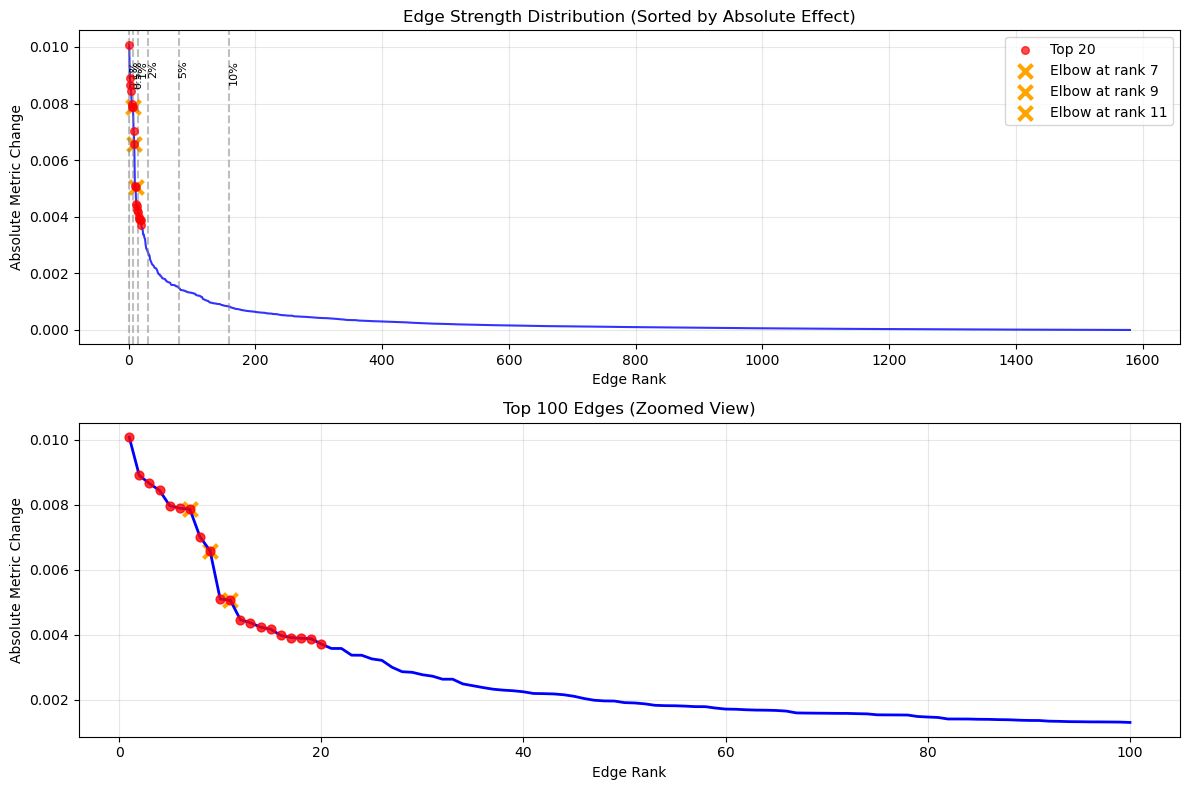


Edge Strength Distribution Statistics:
Total edges: 1580
Strongest edge: 0.010083
Median edge strength: 0.000102
Mean edge strength: 0.000348

Percentile thresholds:
Top  0.1%: 0.010083 (rank 1)
Top  0.5%: 0.007866 (rank 7)
Top  1.0%: 0.004173 (rank 15)
Top  2.0%: 0.002729 (rank 31)
Top  5.0%: 0.001488 (rank 79)
Top 10.0%: 0.000826 (rank 158)


In [ ]:
# Create edge strength distribution plot
print("\n" + "="*80)
print("EDGE STRENGTH DISTRIBUTION ANALYSIS")
print("="*80)

abs_strengths, ranks = plot_edge_strength_distribution(path_patching_results, top_n=None, show_elbow=True)

In [ ]:
!pip install kneed

In [ ]:
def plot_edge_strength_distribution(path_patching_results, top_n=None, show_elbow=True, figsize=(12, 8)):
    """
    Plot the distribution of absolute edge strengths to identify natural thresholds.
    
    Args:
        path_patching_results: List of path patching results
        top_n: Number of top edges to plot (None = all edges)
        show_elbow: Whether to try automatic elbow detection
        figsize: Figure size tuple
    """
    
    # Get absolute strengths and sort
    abs_strengths = [abs(result[4]) for result in path_patching_results]
    abs_strengths.sort(reverse=True)
    
    if top_n is not None:
        abs_strengths = abs_strengths[:top_n]
    
    ranks = list(range(1, len(abs_strengths) + 1))
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    
    # Main plot: Rank vs Absolute Strength
    ax1.plot(ranks, abs_strengths, 'b-', linewidth=1.5, alpha=0.8)
    ax1.scatter(ranks[:20], abs_strengths[:20], color='red', s=30, alpha=0.7, zorder=5, label='Top 20')
    ax1.set_xlabel('Edge Rank')
    ax1.set_ylabel('Absolute Metric Change')
    ax1.set_title('Edge Strength Distribution (Sorted by Absolute Effect)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Add percentile markers
    percentiles = [0.1, 0.5, 1, 2, 5, 10]
    for p in percentiles:
        idx = int(len(abs_strengths) * p / 100) - 1
        if 0 <= idx < len(abs_strengths):
            ax1.axvline(x=idx+1, color='gray', linestyle='--', alpha=0.5)
            ax1.text(idx+1, ax1.get_ylim()[1]*0.9, f'{p}%', rotation=90, 
                    verticalalignment='top', fontsize=8)
    
    # Zoom in on top edges
    zoom_n = min(100, len(abs_strengths))
    ax2.plot(ranks[:zoom_n], abs_strengths[:zoom_n], 'b-', linewidth=2)
    ax2.scatter(ranks[:20], abs_strengths[:20], color='red', s=40, alpha=0.8, zorder=5)
    ax2.set_xlabel('Edge Rank')
    ax2.set_ylabel('Absolute Metric Change')
    ax2.set_title(f'Top {zoom_n} Edges (Zoomed View)')
    ax2.grid(True, alpha=0.3)
    
    # Try automatic elbow detection if requested
    if show_elbow and len(abs_strengths) > 10:
        elbow_points = find_elbow_points(abs_strengths, ranks)
        if elbow_points:
            for elbow_rank, elbow_strength in elbow_points[:3]:  # Show top 3 elbow points
                ax1.scatter([elbow_rank], [elbow_strength], color='orange', s=100, 
                           marker='x', linewidth=3, label=f'Elbow at rank {elbow_rank}')
                if elbow_rank <= zoom_n:
                    ax2.scatter([elbow_rank], [elbow_strength], color='orange', s=100, 
                               marker='x', linewidth=3)
            ax1.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"\nEdge Strength Distribution Statistics:")
    print(f"Total edges: {len(path_patching_results)}")
    print(f"Strongest edge: {max(abs_strengths):.6f}")
    print(f"Median edge strength: {np.median(abs_strengths):.6f}")
    print(f"Mean edge strength: {np.mean(abs_strengths):.6f}")
    
    print(f"\nPercentile thresholds:")
    for p in [0.1, 0.5, 1, 2, 5, 10]:
        idx = int(len(abs_strengths) * p / 100) - 1
        if 0 <= idx < len(abs_strengths):
            threshold = abs_strengths[idx]
            print(f"Top {p:4.1f}%: {threshold:.6f} (rank {idx+1})")
    
    return abs_strengths, ranks

def find_elbow_points(strengths, ranks, method='knee'):
    """
    Find elbow/knee points in the edge strength distribution.
    
    Args:
        strengths: List of absolute strengths (sorted descending)
        ranks: List of corresponding ranks
        method: Method to use ('knee', 'gradient', 'curvature')
    
    Returns:
        List of (rank, strength) tuples for detected elbow points
    """
    
    if len(strengths) < 10:
        return []
    
    elbow_points = []
    
    if method == 'knee':
        try:
            from kneed import KneeLocator
            kl = KneeLocator(ranks, strengths, curve='convex', direction='decreasing')
            if kl.knee:
                elbow_points.append((kl.knee, strengths[kl.knee-1]))
        except ImportError:
            print("Install kneed package for automatic elbow detection: pip install kneed")
            method = 'gradient'  # Fallback
    
    if method == 'gradient' or not elbow_points:
        # Simple gradient-based approach
        gradients = np.diff(strengths)
        gradient_changes = np.diff(gradients)
        
        # Find points where gradient change is largest (biggest drops in slope)
        candidates = np.argsort(gradient_changes)[:5]  # Top 5 candidates
        for idx in candidates:
            rank = idx + 2  # Adjust for double diff
            if 5 <= rank <= len(strengths) - 5:  # Avoid edges
                elbow_points.append((rank, strengths[rank-1]))
    
    # Sort by rank
    elbow_points.sort(key=lambda x: x[0])
    return elbow_points[:5]  # Return top 5

def suggest_thresholds(path_patching_results, methods=['percentile', 'elbow', 'zscore']):
    """
    Suggest different threshold methods for selecting strong edges.
    
    Args:
        path_patching_results: List of path patching results
        methods: List of threshold methods to try
    
    Returns:
        Dictionary of threshold suggestions
    """
    
    abs_strengths = [abs(result[4]) for result in path_patching_results]
    abs_strengths.sort(reverse=True)
    
    suggestions = {}
    
    if 'percentile' in methods:
        percentiles = [0.1, 0.5, 1, 2, 5, 10]
        suggestions['percentile'] = {}
        for p in percentiles:
            idx = int(len(abs_strengths) * p / 100) - 1
            if 0 <= idx < len(abs_strengths):
                suggestions['percentile'][f'top_{p}%'] = {
                    'threshold': abs_strengths[idx],
                    'n_edges': idx + 1,
                    'rank': idx + 1
                }
    
    if 'elbow' in methods:
        elbow_points = find_elbow_points(abs_strengths, list(range(1, len(abs_strengths)+1)))
        if elbow_points:
            suggestions['elbow'] = {}
            for i, (rank, strength) in enumerate(elbow_points[:3]):
                suggestions['elbow'][f'elbow_{i+1}'] = {
                    'threshold': strength,
                    'n_edges': rank,
                    'rank': rank
                }
    
    if 'zscore' in methods:
        mean_abs = np.mean(abs_strengths)
        std_abs = np.std(abs_strengths)
        z_thresholds = [1.0, 1.5, 2.0, 2.5, 3.0]
        suggestions['zscore'] = {}
        
        for z in z_thresholds:
            threshold = mean_abs + z * std_abs
            n_above = sum(1 for s in abs_strengths if s >= threshold)
            if n_above > 0:
                suggestions['zscore'][f'z_{z}'] = {
                    'threshold': threshold,
                    'n_edges': n_above,
                    'rank': n_above
                }
    
    return suggestions

def print_threshold_suggestions(suggestions):
    """Print formatted threshold suggestions"""
    print(f"\n{'='*80}")
    print(f"THRESHOLD SUGGESTIONS")
    print(f"{'='*80}")
    
    for method, thresholds in suggestions.items():
        print(f"\n{method.upper()} Method:")
        print(f"{'Name':<12} {'Threshold':<12} {'# Edges':<10} {'Rank':<8}")
        print(f"{'-'*45}")
        
        for name, info in thresholds.items():
            print(f"{name:<12} {info['threshold']:<12.6f} {info['n_edges']:<10} {info['rank']:<8}")


EDGE STRENGTH DISTRIBUTION ANALYSIS


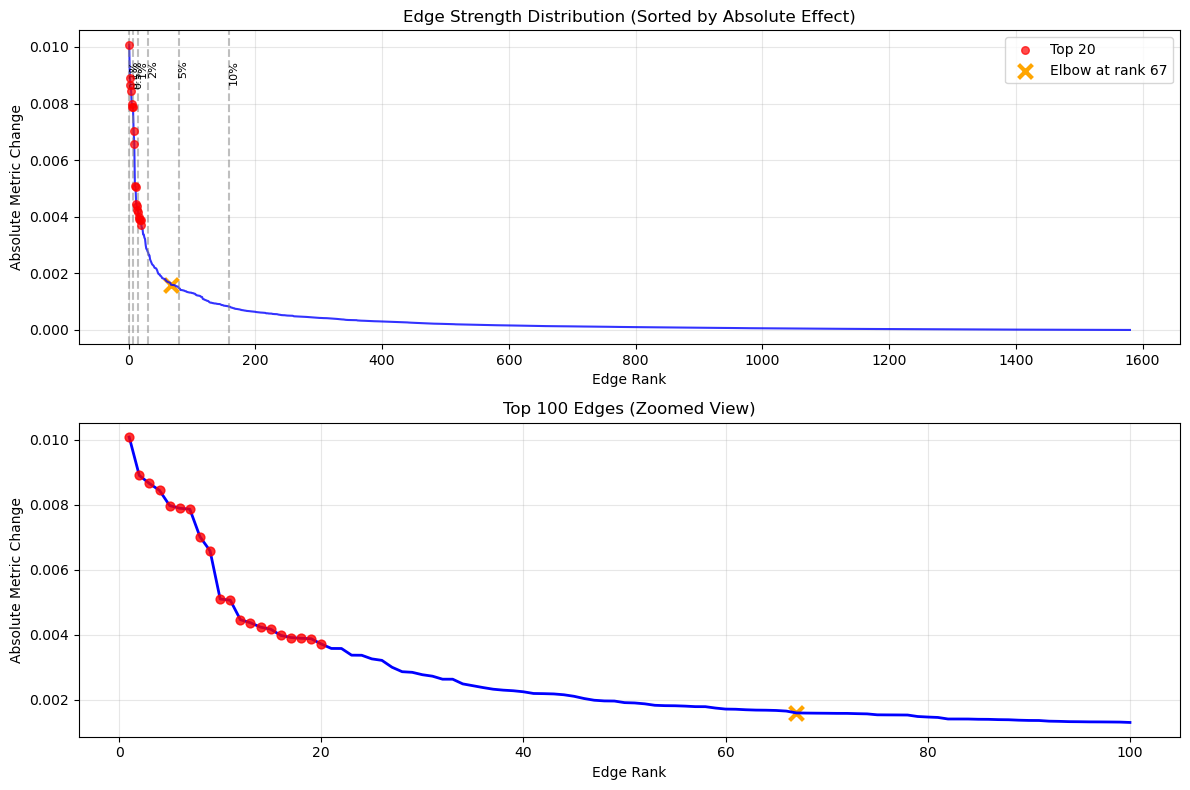


Edge Strength Distribution Statistics:
Total edges: 1580
Strongest edge: 0.010083
Median edge strength: 0.000102
Mean edge strength: 0.000348

Percentile thresholds:
Top  0.1%: 0.010083 (rank 1)
Top  0.5%: 0.007866 (rank 7)
Top  1.0%: 0.004173 (rank 15)
Top  2.0%: 0.002729 (rank 31)
Top  5.0%: 0.001488 (rank 79)
Top 10.0%: 0.000826 (rank 158)


In [ ]:
# Create edge strength distribution plot
print("\n" + "="*80)
print("EDGE STRENGTH DISTRIBUTION ANALYSIS")
print("="*80)

abs_strengths, ranks = plot_edge_strength_distribution(path_patching_results, top_n=None, show_elbow=True)

In [ ]:
# Get threshold suggestions
suggestions = suggest_thresholds(path_patching_results)
print_threshold_suggestions(suggestions)


THRESHOLD SUGGESTIONS

PERCENTILE Method:
Name         Threshold    # Edges    Rank    
---------------------------------------------
top_0.1%     0.010083     1          1       
top_0.5%     0.007866     7          7       
top_1%       0.004173     15         15      
top_2%       0.002729     31         31      
top_5%       0.001488     79         79      
top_10%      0.000826     158        158     

ELBOW Method:
Name         Threshold    # Edges    Rank    
---------------------------------------------
elbow_1      0.001599     67         67      

ZSCORE Method:
Name         Threshold    # Edges    Rank    
---------------------------------------------
z_1.0        0.001176     113        113     
z_1.5        0.001590     69         69      
z_2.0        0.002004     46         46      
z_2.5        0.002418     35         35      
z_3.0        0.002831     29         29      


Connected to finetuning (Python 3.10.4)

In [ ]:
# Import necessary libraries and functions from helper modules
import sys
sys.path.append('../plm_circuits')

# Import utility functions
from helpers.utils import (
    clear_memory,
    load_esm,
    load_sae_prot,
    mask_flanks_segment,
    patching_metric,
    cleanup_cuda
)

# Import attribution functions
from attribution import (
    integrated_gradients_sae,
    topk_sae_err_pt
)

# Import hook classes
from hook_manager import SAEHookProt

# Additional imports
import json
from functools import partial
import torch
import numpy as np
import matplotlib.pyplot as plt
import collections

In IPython
Set autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
In IPython
Set autoreload


In [ ]:
# Setup device and load models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load ESM-2 model
esm_transformer, batch_converter, esm2_alphabet = load_esm(33, device=device)

# Load SAEs for multiple layers
main_layers = [4, 8, 12, 16, 20, 24, 28]
saes = []
for layer in main_layers:
    sae_model = load_sae_prot(ESM_DIM=1280, SAE_DIM=4096, LAYER=layer, device=device)
    saes.append(sae_model)

layer_2_saelayer = {layer: layer_idx for layer_idx, layer in enumerate(main_layers)}

Using device: cuda


In [ ]:
# Load sequence data and define protein parameters
with open('../data/full_seq_dict.json', "r") as json_file:
    seq_dict = json.load(json_file)

# Define protein-specific parameters
sse_dict = {"2B61A": [[182, 316]], "1PVGA": [[101, 202]]}
fl_dict = {"2B61A": [44, 43], "1PVGA": [65, 63]}

# Choose protein for analysis
protein = "2B61A"
seq = seq_dict[protein]
position = sse_dict[protein][0]

# Define segment boundaries
ss1_start = position[0] - 5 
ss1_end = position[0] + 5 + 1 
ss2_start = position[1] - 5 
ss2_end = position[1] + 5 + 1 

print(f"Analyzing protein: {protein}")
print(f"Sequence length: {len(seq)}")
print(f"Segment 1: {ss1_start}-{ss1_end}")
print(f"Segment 2: {ss2_start}-{ss2_end}")

Analyzing protein: 2B61A
Sequence length: 377
Segment 1: 177-188
Segment 2: 311-322


In [ ]:
# Prepare full sequence and get baseline contact predictions
full_seq_L = [(1, seq)]
_, _, batch_tokens_BL = batch_converter(full_seq_L)
batch_tokens_BL = batch_tokens_BL.to(device)
batch_mask_BL = (batch_tokens_BL != esm2_alphabet.padding_idx).to(device)

with torch.no_grad():
    full_seq_contact_LL = esm_transformer.predict_contacts(batch_tokens_BL, batch_mask_BL)[0]

# Prepare clean sequence (with optimal flanks)
clean_fl = fl_dict[protein][0]
L = len(seq)
left_start = max(0, ss1_start - clean_fl)
left_end = ss1_start
right_start = ss2_end
right_end = min(L, ss2_end + clean_fl)
unmask_left_idxs = list(range(left_start, left_end))
unmask_right_idxs = list(range(right_start, right_end))

clean_seq_L = mask_flanks_segment(seq, ss1_start, ss1_end, ss2_start, ss2_end, unmask_left_idxs, unmask_right_idxs)
_, _, clean_batch_tokens_BL = batch_converter([(1, clean_seq_L)])
clean_batch_tokens_BL = clean_batch_tokens_BL.to(device)
clean_batch_mask_BL = (clean_batch_tokens_BL != esm2_alphabet.padding_idx).to(device)

with torch.no_grad():
    clean_seq_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]

print(f"Clean flank size: {clean_fl}")
print(f"Clean sequence contact recovery: {patching_metric(clean_seq_contact_LL, full_seq_contact_LL, ss1_start, ss1_end, ss2_start, ss2_end):.4f}")

# Prepare corrupted sequence (with suboptimal flanks)
corr_fl = fl_dict[protein][1]
left_start = max(0, ss1_start - corr_fl)
left_end = ss1_start
right_start = ss2_end
right_end = min(L, ss2_end + corr_fl)
unmask_left_idxs = list(range(left_start, left_end))
unmask_right_idxs = list(range(right_start, right_end))

corr_seq_L = mask_flanks_segment(seq, ss1_start, ss1_end, ss2_start, ss2_end, unmask_left_idxs, unmask_right_idxs)
_, _, corr_batch_tokens_BL = batch_converter([(1, corr_seq_L)])
corr_batch_tokens_BL = corr_batch_tokens_BL.to(device)
corr_batch_mask_BL = (corr_batch_tokens_BL != esm2_alphabet.padding_idx).to(device)

with torch.no_grad():
    corr_seq_contact_LL = esm_transformer.predict_contacts(corr_batch_tokens_BL, corr_batch_mask_BL)[0]

print(f"Corrupted flank size: {corr_fl}")
print(f"Corrupted sequence contact recovery: {patching_metric(corr_seq_contact_LL, full_seq_contact_LL, ss1_start, ss1_end, ss2_start, ss2_end):.4f}")

# Create patching metric function
_patching_metric = partial(
    patching_metric,
    orig_contact=full_seq_contact_LL,
    ss1_start=ss1_start,
    ss1_end=ss1_end,
    ss2_start=ss2_start,
    ss2_end=ss2_end,
)

Clean flank size: 44
Clean sequence contact recovery: 0.5738
Corrupted flank size: 43
Corrupted sequence contact recovery: 0.0279


In [ ]:
# Perform causal ranking for all latent-token pairs across layers
print("Starting causal ranking with integrated gradients...")

all_effects_sae_ALS = []
all_effects_err_ABLF = []

for layer_idx in main_layers:
    print(f"\nProcessing layer {layer_idx}...")
    
    sae_model = saes[layer_2_saelayer[layer_idx]]

    # Get clean cache and error
    hook = SAEHookProt(sae=sae_model, mask_BL=clean_batch_mask_BL, cache_latents=True, layer_is_lm=False, calc_error=True, use_error=True)
    handle = esm_transformer.esm.encoder.layer[layer_idx].register_forward_hook(hook)
    with torch.no_grad():
        clean_seq_sae_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
    cleanup_cuda()
    handle.remove()
    clean_cache_LS = sae_model.feature_acts
    clean_err_cache_BLF = sae_model.error_term
    clean_contact_recovery = _patching_metric(clean_seq_sae_contact_LL)

    # Get corrupted cache and error
    hook = SAEHookProt(sae=sae_model, mask_BL=corr_batch_mask_BL, cache_latents=True, layer_is_lm=False, calc_error=True, use_error=True)
    handle = esm_transformer.esm.encoder.layer[layer_idx].register_forward_hook(hook)
    with torch.no_grad():
        corr_seq_sae_contact_LL = esm_transformer.predict_contacts(corr_batch_tokens_BL, corr_batch_mask_BL)[0]
    cleanup_cuda()
    handle.remove()
    corr_cache_LS = sae_model.feature_acts
    corr_err_cache_BLF = sae_model.error_term
    corr_contact_recovery = _patching_metric(corr_seq_sae_contact_LL)
    
    print(f"Layer {layer_idx}: Clean contact recovery: {clean_contact_recovery:.4f}, Corr contact recovery: {corr_contact_recovery:.4f}")

    # Run integrated gradients
    effect_sae_LS, effect_err_BLF = integrated_gradients_sae(
        esm_transformer,
        sae_model,
        _patching_metric,
        clean_cache_LS.to(device),
        corr_cache_LS.to(device),
        clean_err_cache_BLF.to(device),
        corr_err_cache_BLF.to(device),
        batch_tokens=clean_batch_tokens_BL,
        batch_mask=clean_batch_mask_BL,
        hook_layer=layer_idx,
    )

    all_effects_sae_ALS.append(effect_sae_LS)
    all_effects_err_ABLF.append(effect_err_BLF)

# Stack all effects
all_effects_sae_ALS = torch.stack(all_effects_sae_ALS)
all_effects_err_ABLF = torch.stack(all_effects_err_ABLF)

print(f"\nCausal ranking complete!")
print(f"SAE effects shape: {all_effects_sae_ALS.shape}")
print(f"Error effects shape: {all_effects_err_ABLF.shape}")

Starting causal ranking with integrated gradients...

Processing layer 4...
Layer 4: Clean contact recovery: 0.5738, Corr contact recovery: 0.0279
ratio: 0.0, score: 0.5737996101379395
ratio: 0.1, score: 0.601131796836853
ratio: 0.2, score: 0.4815935492515564
ratio: 0.30000000000000004, score: 0.4985087811946869
ratio: 0.4, score: 0.3368060886859894
ratio: 0.5, score: 0.2868437170982361
ratio: 0.6000000000000001, score: 0.24697260558605194
ratio: 0.7000000000000001, score: 0.12411289662122726
ratio: 0.8, score: 0.10038772225379944
ratio: 0.9, score: 0.033265773206949234

Processing layer 8...
Layer 8: Clean contact recovery: 0.5738, Corr contact recovery: 0.0279
ratio: 0.0, score: 0.5737998485565186
ratio: 0.1, score: 0.5733504891395569
ratio: 0.2, score: 0.49743935465812683
ratio: 0.30000000000000004, score: 0.4819444417953491
ratio: 0.4, score: 0.4560147225856781
ratio: 0.5, score: 0.3371899425983429
ratio: 0.6000000000000001, score: 0.24517741799354553
ratio: 0.7000000000000001, sco

In [ ]:
print("Creating layer-wise caches for performance analysis...")

clean_layer_caches = {}
corr_layer_caches = {}
clean_layer_errors = {}
corr_layer_errors = {}

for layer_idx in main_layers:
    sae_model = saes[layer_2_saelayer[layer_idx]]
    
    # Clean caches
    hook = SAEHookProt(sae=sae_model, mask_BL=clean_batch_mask_BL, cache_latents=True, 
                       layer_is_lm=False, calc_error=True, use_error=True)
    handle = esm_transformer.esm.encoder.layer[layer_idx].register_forward_hook(hook)
    with torch.no_grad():
        clean_seq_sae_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
    cleanup_cuda()
    handle.remove()
    print(f"Layer {layer_idx}, clean score: {_patching_metric(clean_seq_sae_contact_LL):.4f}")
    clean_layer_caches[layer_idx] = sae_model.feature_acts
    clean_layer_errors[layer_idx] = sae_model.error_term
    # print shapes
    print(clean_layer_caches[layer_idx].shape, clean_layer_errors[layer_idx].shape)

    # Corrupted caches
    hook = SAEHookProt(sae=sae_model, mask_BL=corr_batch_mask_BL, cache_latents=True, 
                       layer_is_lm=False, calc_error=True, use_error=True)
    handle = esm_transformer.esm.encoder.layer[layer_idx].register_forward_hook(hook)
    with torch.no_grad():
        corr_seq_sae_contact_LL = esm_transformer.predict_contacts(corr_batch_tokens_BL, corr_batch_mask_BL)[0]
    cleanup_cuda()
    handle.remove()
    print(f"Layer {layer_idx}, corr score: {_patching_metric(corr_seq_sae_contact_LL):.4f}")
    corr_layer_caches[layer_idx] = sae_model.feature_acts
    corr_layer_errors[layer_idx] = sae_model.error_term

print("Layer-wise caches created successfully!")

Creating layer-wise caches for performance analysis...
Layer 4, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 4, corr score: 0.0279
Layer 8, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 8, corr score: 0.0279
Layer 12, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 12, corr score: 0.0279
Layer 16, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 16, corr score: 0.0279
Layer 20, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 20, corr score: 0.0279
Layer 24, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 24, corr score: 0.0279
Layer 28, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 28, corr score: 0.0279
Layer-wise caches created successfully!


In [ ]:
def patch_top_k_features(target_layer, k_value, all_effects_sae_ALS, clean_layer_caches, corr_layer_caches, 
                        saes, layer_2_saelayer, esm_transformer, clean_batch_tokens_BL, clean_batch_mask_BL, 
                        clean_layer_errors, corr_layer_errors,
                        _patching_metric, device, verbose=False):
    """
    Patch the top-k most important features for a given layer and return recovery score.
    
    Args:
        target_layer: Layer to patch
        k_value: Number of top features to patch
        ... (other arguments are the data structures from above)
        verbose: Whether to print debug info
    
    Returns:
        recovery: Contact recovery score after patching
    """
    
    # Get the SAE model and effects for this layer
    sae_model = saes[layer_2_saelayer[target_layer]]
    
    # Set mean error to clean error for this layer
    sae_model.mean_error = clean_layer_errors[target_layer]
    
    target_effect_sae_LS = all_effects_sae_ALS[layer_2_saelayer[target_layer]]
    target_effect_sae_flat_LxS = target_effect_sae_LS.reshape(-1)
    
    # Get top-k indices
    top_rank_vals, top_idx = torch.topk(target_effect_sae_flat_LxS, k=k_value, largest=False, sorted=True)
    
    # Convert flattened indices back to 2D coordinates
    L, S = target_effect_sae_LS.shape
    row_indices = top_idx // S
    col_indices = top_idx % S
    
    if verbose:
        print(f"Layer {target_layer}, K={k_value}: Top effect = {top_rank_vals[0]:.6f}")
    
    # Create mask - start with all True (patch), set False for positions to not patch
    sae_mask_LS = torch.ones((L, S), dtype=torch.bool, device=device)
    
    for i in range(len(top_idx)):
        row = row_indices[i]
        col = col_indices[i]
        sae_mask_LS[row, col] = False
    
    # Set up hook for patching
    hook = SAEHookProt(
        sae=sae_model,
        mask_BL=clean_batch_mask_BL,
        patch_mask_BLS=sae_mask_LS.to(device),
        patch_value=corr_layer_caches[target_layer].to(device),
        use_mean_error=True,
    )
    handle = esm_transformer.esm.encoder.layer[target_layer].register_forward_hook(hook)
    
    # Forward pass & metric
    with torch.no_grad():
        preds_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
    recovery = _patching_metric(preds_LL)
    
    # Clean up
    handle.remove()
    cleanup_cuda()
    
    # Convert to CPU float for plotting
    if isinstance(recovery, torch.Tensor):
        recovery = recovery.cpu().item()
    
    return recovery

In [ ]:
def sweep_k_values(target_layers, k_values, all_effects_sae_ALS, clean_layer_caches, corr_layer_caches,
                  saes, layer_2_saelayer, esm_transformer, clean_batch_tokens_BL, clean_batch_mask_BL,
                  clean_layer_errors, corr_layer_errors,
                  _patching_metric, device):
    """
    Sweep through k values for multiple target layers and collect recovery scores.
    
    Returns:
        results: Dictionary with layer as key, and (k_values, recoveries) as values
    """
    
    results = {}
    
    for target_layer in target_layers:
        print(f"\nProcessing layer {target_layer}...")
        recoveries = []
        
        for k in k_values:
            recovery = patch_top_k_features(
                target_layer, k, all_effects_sae_ALS, clean_layer_caches, corr_layer_caches,
                saes, layer_2_saelayer, esm_transformer, clean_batch_tokens_BL, clean_batch_mask_BL,
                clean_layer_errors, corr_layer_errors,
                _patching_metric, device, verbose=True
            )
            recoveries.append(recovery)
            
        results[target_layer] = (k_values, recoveries)
        print(f"Layer {target_layer} complete!")
    
    return results

In [ ]:
"""
for neuron1 in l4:
    # get acts of l4 neuron1 when zero ablating or ablating with corrupted seq (prefer corrupted)
    corr_hook 

    # freeze all neuron between two layers to be clean (optional maybe)
    clean_hook 

    for neuron2 in l8:
        # record change in acts of l8 neuron2 when zero ablating or ablating with corrupted seq (prefer corrupted)
        cache_hook 

        # put changed acts of l8 neuron2 in corr_hook 
        corr_hook2 

        # record change in recovery between clean l8 and corrupted hook 2 run 
        IE (neuron1, neuron2) = delta m 
"""

'\nfor neuron1 in l4:\n    # get acts of l4 neuron1 when zero ablating or ablating with corrupted seq (prefer corrupted)\n    corr_hook \n\n    # freeze all neuron between two layers to be clean (optional maybe)\n    clean_hook \n\n    for neuron2 in l8:\n        # record change in acts of l8 neuron2 when zero ablating or ablating with corrupted seq (prefer corrupted)\n        cache_hook \n\n        # put changed acts of l8 neuron2 in corr_hook \n        corr_hook2 \n\n        # record change in recovery between clean l8 and corrupted hook 2 run \n        IE (neuron1, neuron2) = delta m \n'

In [ ]:
L, S = 379, 4096 #all_effects_sae_ALS[layer_2_saelayer[4]].shape

In [ ]:
up_layer = 4
down_layer = 12
intermediate_layer = 8
up_latent = 1000 #1690 # 3326, 3634, 1690
down_latent = 2112 

up_sae_model = saes[layer_2_saelayer[up_layer]]
down_sae_model = saes[layer_2_saelayer[down_layer]]
intermediate_sae_model = saes[layer_2_saelayer[intermediate_layer]]
up_sae_model.mean_error = clean_layer_errors[up_layer]
down_sae_model.mean_error = clean_layer_errors[down_layer]
intermediate_sae_model.mean_error = clean_layer_errors[intermediate_layer]

# We also know the baseline score from when we computed the clean caches
# But let's get it for reference
with torch.no_grad():
    baseline_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
baseline_score = _patching_metric(baseline_contact_LL)
print(f"Baseline score: {baseline_score:.4f}")

Baseline score: 0.5738


In [ ]:
# Setup corruption hook for layer 4
corrupt_hook = SAEHookProt(
    sae=up_sae_model,
    mask_BL=clean_batch_mask_BL,
    patch_latent_S=up_latent,
    patch_value=corr_layer_caches[up_layer][:, up_latent].to(device),
    use_mean_error=True,
)

# Setup caching hook for layer 8
cache_hook = SAEHookProt(
    sae=down_sae_model,
    mask_BL=clean_batch_mask_BL,
    cache_latents=True,
    layer_is_lm=False,
    calc_error=False,
    use_error=False,
    use_mean_error=True
)

# Register both hooks
corrupt_handle = esm_transformer.esm.encoder.layer[up_layer].register_forward_hook(corrupt_hook)
cache_handle = esm_transformer.esm.encoder.layer[down_layer].register_forward_hook(cache_hook)

# Forward pass with corruption
with torch.no_grad():
    corrupted_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]

# Clean up hooks
corrupt_handle.remove()
cache_handle.remove()
cleanup_cuda()

baseline_acts_layer8 = clean_layer_caches[down_layer][:, down_latent].clone()

corrupted_acts_layer8 = saes[layer_2_saelayer[down_layer]].feature_acts[:, down_latent].clone()
print(corrupted_acts_layer8 - baseline_acts_layer8)

tensor([ 8.3447e-07, -2.8610e-06,  2.3842e-06,  3.3379e-06,  7.1526e-07,
        -7.1526e-07,  9.5367e-07,  1.1921e-06,  2.3842e-07,  0.0000e+00,
         1.1921e-06, -1.1921e-06, -2.3842e-06,  0.0000e+00, -2.3842e-06,
         1.4305e-06, -9.5367e-07, -2.6226e-06,  1.6689e-06, -7.1526e-07,
         3.3379e-06,  2.3842e-07, -7.1526e-07,  3.8147e-06, -1.9073e-06,
        -3.5763e-06,  0.0000e+00, -9.5367e-07,  5.4836e-06,  3.3379e-06,
         2.8610e-06,  1.9073e-06,  4.5300e-06,  9.5367e-07, -1.9073e-06,
         0.0000e+00,  3.5763e-06,  4.2915e-06,  2.6226e-06,  4.7684e-07,
         2.3842e-07, -7.1526e-07,  1.9073e-06,  9.5367e-07,  1.4305e-06,
         2.3842e-06,  2.8610e-06,  0.0000e+00,  3.3379e-06,  9.5367e-07,
         3.3379e-06,  2.8610e-06,  4.0531e-06,  9.5367e-07,  2.1458e-06,
         2.8610e-06,  2.1458e-06,  2.6226e-06,  2.3842e-06,  1.6689e-06,
         3.8147e-06,  2.6226e-06,  1.4305e-06, -1.6689e-06,  3.0994e-06,
         0.0000e+00,  2.1458e-06,  2.1458e-06,  7.1

In [ ]:
corrupt_hook2 = SAEHookProt(
    sae=down_sae_model,
    mask_BL=clean_batch_mask_BL,
    patch_latent_S=down_latent,
    patch_value=corrupted_acts_layer8.to(device),
    use_mean_error=True,
)

# Register both hooks
corrupt_handle2 = esm_transformer.esm.encoder.layer[down_layer].register_forward_hook(corrupt_hook2)

# Forward pass with corruption
with torch.no_grad():
    corrupted_contact_LL2 = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]

# Clean up hooks
corrupt_handle2.remove()
cleanup_cuda()

path_corrupted_score = _patching_metric(corrupted_contact_LL2)

print(f"Layer {down_layer}, corr score: {path_corrupted_score:.4f}, change: {path_corrupted_score - baseline_score:.4f}")

Layer 12, corr score: 0.5738, change: 0.0000


In [ ]:
# load the json file 
with open('/work/pi_jensen_umass_edu/jnainani_umass_edu/plm_circuits/results/layer_latent_dict_metx.json', 'r') as f:
    layer_latent_dict_metx = json.load(f)

for layer in layer_latent_dict_metx:
    print(f"Layer {layer}: #latents in metx: {len(layer_latent_dict_metx[layer])}")

Layer 4: #latents in metx: 30
Layer 8: #latents in metx: 11
Layer 12: #latents in metx: 50
Layer 16: #latents in metx: 85
Layer 20: #latents in metx: 95
Layer 24: #latents in metx: 124
Layer 28: #latents in metx: 29


In [ ]:
def compute_path_patching_effect(up_layer, up_latent, down_layer, down_latent, 
                                saes, layer_2_saelayer, clean_layer_caches, corr_layer_caches, 
                                clean_layer_errors, esm_transformer, clean_batch_tokens_BL, 
                                clean_batch_mask_BL, _patching_metric, device, baseline_score):
    """
    Compute the path patching effect for a single upstream-downstream latent pair.
    
    This implements steps C and D:
    - Step C: Ablate upstream latent and record change in downstream latent
    - Step D: Set changed downstream activation and measure final metric change
    
    Args:
        up_layer, down_layer: Layer indices
        up_latent, down_latent: Latent indices  
        ... (other arguments are the shared data structures)
        baseline_score: The clean baseline score for comparison
        
    Returns:
        metric_change: Change in metric score (step D result - baseline)
    """
    
    try:
        # Get SAE models and set mean errors
        up_sae_model = saes[layer_2_saelayer[up_layer]]
        down_sae_model = saes[layer_2_saelayer[down_layer]]
        up_sae_model.mean_error = clean_layer_errors[up_layer]
        down_sae_model.mean_error = clean_layer_errors[down_layer]
        
        # Step C: Ablate upstream and record downstream change
        
        # Setup corruption hook for upstream layer
        corrupt_hook = SAEHookProt(
            sae=up_sae_model,
            mask_BL=clean_batch_mask_BL,
            patch_latent_S=up_latent,
            patch_value=corr_layer_caches[up_layer][:, up_latent].to(device),
            use_mean_error=True,
        )
        
        # Setup caching hook for downstream layer
        cache_hook = SAEHookProt(
            sae=down_sae_model,
            mask_BL=clean_batch_mask_BL,
            cache_latents=True,
            layer_is_lm=False,
            calc_error=False,
            use_error=False,
            use_mean_error=True
        )
        
        # Register both hooks
        corrupt_handle = esm_transformer.esm.encoder.layer[up_layer].register_forward_hook(corrupt_hook)
        cache_handle = esm_transformer.esm.encoder.layer[down_layer].register_forward_hook(cache_hook)
        
        # Forward pass with corruption
        with torch.no_grad():
            _ = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
        
        # Get baseline and corrupted activations for downstream latent
        # baseline_acts_down = clean_layer_caches[down_layer][:, down_latent].clone()
        corrupted_acts_down = down_sae_model.feature_acts[:, down_latent].clone()
        
        # Clean up hooks from step C
        corrupt_handle.remove()
        cache_handle.remove()
        cleanup_cuda()
        
        # Step D: Set changed downstream activation and measure metric
        
        corrupt_hook2 = SAEHookProt(
            sae=down_sae_model,
            mask_BL=clean_batch_mask_BL,
            patch_latent_S=down_latent,
            patch_value=corrupted_acts_down.to(device),
            use_mean_error=True,
        )
        
        # Register hook
        corrupt_handle2 = esm_transformer.esm.encoder.layer[down_layer].register_forward_hook(corrupt_hook2)
        
        # Forward pass with downstream corruption
        with torch.no_grad():
            final_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
        
        # Clean up hook from step D
        corrupt_handle2.remove()
        cleanup_cuda()
        
        # Calculate final metric change
        final_score = _patching_metric(final_contact_LL)
        metric_change = final_score - baseline_score
        
        # Convert to CPU float if tensor
        if isinstance(metric_change, torch.Tensor):
            metric_change = metric_change.cpu().item()
            
        return metric_change
        
    except Exception as e:
        print(f"Error processing up_layer={up_layer}, up_latent={up_latent}, down_layer={down_layer}, down_latent={down_latent}: {e}")
        return None

In [ ]:
def compute_all_path_patching_effects(layer_latent_dict, saes, layer_2_saelayer, clean_layer_caches, 
                                     corr_layer_caches, clean_layer_errors, esm_transformer, 
                                     clean_batch_tokens_BL, clean_batch_mask_BL, _patching_metric, 
                                     device, baseline_score):
    """
    Compute path patching effects for all valid layer-latent combinations.
    
    Args:
        layer_latent_dict: Dictionary with layer numbers as keys and lists of latent indices as values
        ... (other arguments are the shared data structures)
        
    Returns:
        results: List of tuples (up_layer, up_latent, down_layer, down_latent, metric_change)
                sorted by metric_change (most negative = strongest effect)
    """
    
    results = []
    total_combinations = 0
    processed_combinations = 0
    
    # Convert layer keys to integers and sort
    layers = sorted([int(layer) for layer in layer_latent_dict.keys()])
    
    # Count total combinations for progress tracking
    for i, up_layer in enumerate(layers):
        for j, down_layer in enumerate(layers):
            if up_layer < down_layer:  # Only test causal direction
                up_latents = layer_latent_dict[str(up_layer)]
                down_latents = layer_latent_dict[str(down_layer)]
                total_combinations += len(up_latents) * len(down_latents)
    
    print(f"Total combinations to test: {total_combinations}")
    
    # Test all layer pairs in causal order
    for i, up_layer in enumerate(layers):
        for j, down_layer in enumerate(layers):
            if up_layer >= down_layer:  # Skip non-causal directions
                continue
                
            print(f"\nTesting layer {up_layer} → layer {down_layer}")
            
            up_latents = layer_latent_dict[str(up_layer)]
            down_latents = layer_latent_dict[str(down_layer)]
            
            # Test all latent combinations for this layer pair
            for up_latent in up_latents:
                for down_latent in down_latents:
                    
                    metric_change = compute_path_patching_effect(
                        up_layer, up_latent, down_layer, down_latent,
                        saes, layer_2_saelayer, clean_layer_caches, corr_layer_caches,
                        clean_layer_errors, esm_transformer, clean_batch_tokens_BL,
                        clean_batch_mask_BL, _patching_metric, device, baseline_score
                    )
                    
                    if metric_change is not None:
                        results.append((up_layer, up_latent, down_layer, down_latent, metric_change))
                    
                    processed_combinations += 1
                    if processed_combinations % 100 == 0:
                        print(f"Progress: {processed_combinations}/{total_combinations} ({100*processed_combinations/total_combinations:.1f}%)")
    
    # Sort by metric change (most negative = strongest effect)
    results.sort(key=lambda x: x[4])
    
    print(f"\nCompleted! Processed {len(results)} valid combinations out of {total_combinations} total.")
    
    return results

In [ ]:
# Load the JSON file with layer-latent combinations
with open('/work/pi_jensen_umass_edu/jnainani_umass_edu/plm_circuits/results/layer_latent_dict_metx.json', 'r') as f:
    layer_latent_dict_metx = json.load(f)

print("Layer-latent combinations loaded:")
for layer in sorted(layer_latent_dict_metx.keys(), key=int):
    print(f"Layer {layer}: {len(layer_latent_dict_metx[layer])} latents")

# Get baseline score for comparison
with torch.no_grad():
    baseline_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
baseline_score = _patching_metric(baseline_contact_LL)
print(f"\nBaseline score: {baseline_score:.4f}")

Layer-latent combinations loaded:
Layer 4: 30 latents
Layer 8: 11 latents
Layer 12: 50 latents
Layer 16: 85 latents
Layer 20: 95 latents
Layer 24: 124 latents
Layer 28: 29 latents

Baseline score: 0.5738


In [ ]:
# Load the results
with open('../results/path_patching_results_metx_top3layers.json', 'r') as f:
    results_data = json.load(f)

path_patching_results = results_data['path_patching_results']

In [ ]:
# Additional analysis functions

def get_results_by_absolute_change(path_patching_results, top_k=20):
    """Sort results by absolute metric change (strongest effects regardless of sign)"""
    abs_sorted = sorted(path_patching_results, key=lambda x: abs(x[4]), reverse=True)
    
    print(f"\nTop {top_k} strongest effects by absolute metric change:")
    print("Rank | Up Layer | Up Latent | Down Layer | Down Latent | Metric Change | |Change|")
    print("-" * 80)
    
    for i, (up_layer, up_latent, down_layer, down_latent, metric_change) in enumerate(abs_sorted[:top_k]):
        print(f"{i+1:4d} | {up_layer:8d} | {up_latent:9d} | {down_layer:10d} | {down_latent:11d} | {metric_change:13.6f} | {abs(metric_change):8.6f}")
    
    return abs_sorted

def get_paths_for_upstream_latent(path_patching_results, target_up_layer, target_up_latent, top_k=10):
    """Get top paths for a specific upstream latent"""
    matching_paths = [(up_layer, up_latent, down_layer, down_latent, metric_change) 
                      for up_layer, up_latent, down_layer, down_latent, metric_change in path_patching_results
                      if up_layer == target_up_layer and up_latent == target_up_latent]
    
    # Sort by metric change (most negative = strongest)
    matching_paths.sort(key=lambda x: x[4])
    
    print(f"\nTop {top_k} paths from Layer {target_up_layer}, Latent {target_up_latent}:")
    print("Rank | Down Layer | Down Latent | Metric Change")
    print("-" * 50)
    
    for i, (_, _, down_layer, down_latent, metric_change) in enumerate(matching_paths[:top_k]):
        print(f"{i+1:4d} | {down_layer:10d} | {down_latent:11d} | {metric_change:13.6f}")
    
    return matching_paths

def get_paths_for_downstream_latent(path_patching_results, target_down_layer, target_down_latent, top_k=10):
    """Get top paths for a specific downstream latent"""
    matching_paths = [(up_layer, up_latent, down_layer, down_latent, metric_change) 
                      for up_layer, up_latent, down_layer, down_latent, metric_change in path_patching_results
                      if down_layer == target_down_layer and down_latent == target_down_latent]
    
    # Sort by metric change (most negative = strongest)
    matching_paths.sort(key=lambda x: x[4])
    
    print(f"\nTop {top_k} paths to Layer {target_down_layer}, Latent {target_down_latent}:")
    print("Rank | Up Layer | Up Latent | Metric Change")
    print("-" * 45)
    
    for i, (up_layer, up_latent, _, _, metric_change) in enumerate(matching_paths[:top_k]):
        print(f"{i+1:4d} | {up_layer:8d} | {up_latent:9d} | {metric_change:13.6f}")
    
    return matching_paths

def get_layer_pair_analysis(path_patching_results, up_layer, down_layer, top_k=10):
    """Analyze all paths between two specific layers"""
    matching_paths = [(up_layer_r, up_latent, down_layer_r, down_latent, metric_change) 
                      for up_layer_r, up_latent, down_layer_r, down_latent, metric_change in path_patching_results
                      if up_layer_r == up_layer and down_layer_r == down_layer]
    
    # Sort by metric change (most negative = strongest)
    matching_paths.sort(key=lambda x: x[4])
    
    print(f"\nTop {top_k} paths between Layer {up_layer} → Layer {down_layer}:")
    print("Rank | Up Latent | Down Latent | Metric Change")
    print("-" * 50)
    
    for i, (_, up_latent, _, down_latent, metric_change) in enumerate(matching_paths[:top_k]):
        print(f"{i+1:4d} | {up_latent:9d} | {down_latent:11d} | {metric_change:13.6f}")
    
    return matching_paths

def get_edge_strength_metrics(path_patching_results, target_up_layer, target_up_latent, 
                             target_down_layer, target_down_latent):
    """
    Get comprehensive strength metrics for a specific edge relative to all other edges.
    
    Args:
        path_patching_results: List of all path patching results
        target_up_layer, target_up_latent: Upstream latent to analyze
        target_down_layer, target_down_latent: Downstream latent to analyze
        
    Returns:
        dict: Comprehensive metrics about this edge's relative importance
    """
    
    # Find the target edge
    target_edge = None
    for up_layer, up_latent, down_layer, down_latent, metric_change in path_patching_results:
        if (up_layer == target_up_layer and up_latent == target_up_latent and 
            down_layer == target_down_layer and down_latent == target_down_latent):
            target_edge = (up_layer, up_latent, down_layer, down_latent, metric_change)
            break
    
    if target_edge is None:
        print(f"Edge not found: Layer {target_up_layer}, Latent {target_up_latent} → Layer {target_down_layer}, Latent {target_down_latent}")
        return None
    
    target_metric_change = target_edge[4]
    all_changes = [result[4] for result in path_patching_results]
    all_abs_changes = [abs(change) for change in all_changes]
    
    # 1. Global rank by metric change (most negative = rank 1)
    sorted_by_change = sorted(path_patching_results, key=lambda x: x[4])
    rank_by_change = next(i for i, edge in enumerate(sorted_by_change, 1) 
                         if edge[1] == target_up_latent and edge[0] == target_up_layer and 
                            edge[2] == target_down_layer and edge[3] == target_down_latent)
    
    # 2. Global rank by absolute change (strongest effect = rank 1)
    sorted_by_abs_change = sorted(path_patching_results, key=lambda x: abs(x[4]), reverse=True)
    rank_by_abs_change = next(i for i, edge in enumerate(sorted_by_abs_change, 1) 
                             if edge[1] == target_up_latent and edge[0] == target_up_layer and 
                                edge[2] == target_down_layer and edge[3] == target_down_latent)
    
    # 3. Percentiles (showing "stronger than X% of edges")
    percentile_by_change = 100 - ((rank_by_change / len(path_patching_results)) * 100)
    percentile_by_abs_change = 100 - ((rank_by_abs_change / len(path_patching_results)) * 100)
    
    # 4. Z-scores (focus on absolute values, but keep signed for reference)
    mean_abs_change = np.mean(all_abs_changes)
    std_abs_change = np.std(all_abs_changes)
    z_score_abs_change = (abs(target_metric_change) - mean_abs_change) / std_abs_change if std_abs_change > 0 else 0
    
    # Signed stats for optional reference
    mean_change = np.mean(all_changes)
    std_change = np.std(all_changes)
    z_score_change = (target_metric_change - mean_change) / std_change if std_change > 0 else 0
    
    # 5. Relative strength measures
    strongest_negative = min(all_changes)
    strongest_positive = max(all_changes)
    strongest_absolute = max(all_abs_changes)
    
    relative_to_strongest_negative = target_metric_change / strongest_negative if strongest_negative != 0 else 0
    relative_to_strongest_absolute = abs(target_metric_change) / strongest_absolute if strongest_absolute != 0 else 0
    
    # 6. Layer-specific ranks (how does this edge rank within its layer pair?)
    same_layer_pair = [(up, up_lat, down, down_lat, change) for up, up_lat, down, down_lat, change in path_patching_results
                       if up == target_up_layer and down == target_down_layer]
    
    if len(same_layer_pair) > 1:
        # Sort by absolute change for layer pair ranking
        same_layer_sorted = sorted(same_layer_pair, key=lambda x: abs(x[4]), reverse=True)
        layer_pair_rank = next(i for i, edge in enumerate(same_layer_sorted, 1)
                              if edge[1] == target_up_latent and edge[3] == target_down_latent)
        layer_pair_percentile = 100 - ((layer_pair_rank / len(same_layer_pair)) * 100)
    else:
        layer_pair_rank = 1
        layer_pair_percentile = 100.0
    
    # Compile results
    metrics = {
        'edge': f"Layer {target_up_layer}, Latent {target_up_latent} → Layer {target_down_layer}, Latent {target_down_latent}",
        'metric_change': target_metric_change,
        'abs_metric_change': abs(target_metric_change),
        
        # Global rankings
        'global_rank_by_change': rank_by_change,
        'global_rank_by_abs_change': rank_by_abs_change,
        'total_edges': len(path_patching_results),
        
        # Percentiles (higher = stronger)
        'percentile_by_change': percentile_by_change,
        'percentile_by_abs_change': percentile_by_abs_change,
        
        # Z-scores (higher absolute = more extreme)
        'z_score_change': z_score_change,
        'z_score_abs_change': z_score_abs_change,
        
        # Relative strength (fraction of strongest effect)
        'relative_to_strongest_negative': relative_to_strongest_negative,
        'relative_to_strongest_absolute': relative_to_strongest_absolute,
        
        # Layer-pair specific
        'layer_pair_rank': layer_pair_rank,
        'layer_pair_total': len(same_layer_pair),
        'layer_pair_percentile': layer_pair_percentile,
        
        # Context
        'strongest_negative_change': strongest_negative,
        'strongest_positive_change': strongest_positive,
        'strongest_absolute_change': strongest_absolute,
        'mean_change': mean_change,
        'std_change': std_change,
        'mean_abs_change': mean_abs_change,
        'std_abs_change': std_abs_change
    }
    
    return metrics

def print_edge_strength_report(metrics, show_signed_stats=False):
    """Print a nice formatted report of edge strength metrics"""
    if metrics is None:
        return
        
    print(f"\n{'='*80}")
    print(f"EDGE STRENGTH ANALYSIS")
    print(f"{'='*80}")
    print(f"Edge: {metrics['edge']}")
    print(f"Metric Change: {metrics['metric_change']:.6f}")
    print(f"Absolute Change: {metrics['abs_metric_change']:.6f}")
    
    print(f"\n{'GLOBAL RANKINGS':-^60}")
    print(f"Rank by absolute change:   {metrics['global_rank_by_abs_change']:4d} / {metrics['total_edges']} (stronger than {metrics['percentile_by_abs_change']:.1f}% of edges)")
    if show_signed_stats:
        print(f"Rank by metric change:     {metrics['global_rank_by_change']:4d} / {metrics['total_edges']} (stronger than {metrics['percentile_by_change']:.1f}% of edges)")
    
    print(f"\n{'STATISTICAL MEASURES':-^60}")
    print(f"Z-score (absolute change): {metrics['z_score_abs_change']:8.3f}  {'[Very strong]' if abs(metrics['z_score_abs_change']) > 2.0 else '[Moderate]' if abs(metrics['z_score_abs_change']) > 1.0 else '[Weak]'}")
    if show_signed_stats:
        print(f"Z-score (metric change):   {metrics['z_score_change']:8.3f}")
    
    print(f"\n{'RELATIVE STRENGTH':-^60}")
    print(f"Fraction of strongest absolute effect: {metrics['relative_to_strongest_absolute']:6.3f}")
    if show_signed_stats and metrics['metric_change'] < 0:
        print(f"Fraction of strongest negative effect: {metrics['relative_to_strongest_negative']:6.3f}")
    
    print(f"\n{'LAYER PAIR COMPARISON':-^60}")
    print(f"Rank within Layer {metrics['edge'].split()[1]} → Layer {metrics['edge'].split()[6]} pair: {metrics['layer_pair_rank']:3d} / {metrics['layer_pair_total']} (stronger than {metrics['layer_pair_percentile']:.1f}% within layer pair)")
    
    print(f"\n{'CONTEXT':-^60}")
    print(f"Strongest absolute change: {metrics['strongest_absolute_change']:.6f}")
    print(f"Mean absolute change: {metrics['mean_abs_change']:.6f} ± {metrics['std_abs_change']:.6f}")
    if show_signed_stats:
        print(f"Strongest negative change: {metrics['strongest_negative_change']:.6f}")
        print(f"Strongest positive change: {metrics['strongest_positive_change']:.6f}")
        print(f"Mean signed change: {metrics['mean_change']:.6f} ± {metrics['std_change']:.6f}")

In [ ]:
# Run additional analyses
print("\n" + "="*80)
print("ADDITIONAL ANALYSES")
print("="*80)

# 1. Sort by absolute change
abs_sorted_results = get_results_by_absolute_change(path_patching_results, top_k=20)


ADDITIONAL ANALYSES


KeyError: 4

In [ ]:
# 2. Example upstream latent analysis (using the strongest from original results)
print("\n" + "-"*60)
get_paths_for_upstream_latent(path_patching_results, target_up_layer=4, target_up_latent=1690, top_k=30)

: 

In [ ]:
# 3. Example downstream latent analysis
print("\n" + "-"*60)
get_paths_for_downstream_latent(path_patching_results, target_down_layer=12, target_down_latent=2112, top_k=20)

# 4. Layer pair analysis
# print("\n" + "-"*60)
# get_layer_pair_analysis(path_patching_results, up_layer=4, down_layer=12, top_k=15)

# print("\n" + "-"*60)
# get_layer_pair_analysis(path_patching_results, up_layer=4, down_layer=8, top_k=10)

# print("\n" + "-"*60)
# get_layer_pair_analysis(path_patching_results, up_layer=8, down_layer=12, top_k=10)

: 

In [ ]:
# Load the results
with open('../results/path_patching_results_metx_top3layers.json', 'r') as f:
    results_data = json.load(f)

# Convert back to tuple format (up_layer, up_latent, down_layer, down_latent, metric_change)
path_patching_results = [
    (result['up_layer'], result['up_latent'], result['down_layer'], result['down_latent'], result['metric_change'])
    for result in results_data['path_patching_results']
]

print(f"Loaded {len(path_patching_results)} path patching results")
baseline_score = results_data['baseline_score']
print(f"Baseline score: {baseline_score:.6f}")

Loaded 1580 path patching results
Baseline score: 0.573799


In [ ]:
# Additional analysis functions

def get_results_by_absolute_change(path_patching_results, top_k=20):
    """Sort results by absolute metric change (strongest effects regardless of sign)"""
    abs_sorted = sorted(path_patching_results, key=lambda x: abs(x[4]), reverse=True)
    
    print(f"\nTop {top_k} strongest effects by absolute metric change:")
    print("Rank | Up Layer | Up Latent | Down Layer | Down Latent | Metric Change | |Change|")
    print("-" * 80)
    
    for i, (up_layer, up_latent, down_layer, down_latent, metric_change) in enumerate(abs_sorted[:top_k]):
        print(f"{i+1:4d} | {up_layer:8d} | {up_latent:9d} | {down_layer:10d} | {down_latent:11d} | {metric_change:13.6f} | {abs(metric_change):8.6f}")
    
    return abs_sorted

def get_paths_for_upstream_latent(path_patching_results, target_up_layer, target_up_latent, top_k=10):
    """Get top paths for a specific upstream latent"""
    matching_paths = [(up_layer, up_latent, down_layer, down_latent, metric_change) 
                      for up_layer, up_latent, down_layer, down_latent, metric_change in path_patching_results
                      if up_layer == target_up_layer and up_latent == target_up_latent]
    
    # Sort by metric change (most negative = strongest)
    matching_paths.sort(key=lambda x: x[4])
    
    print(f"\nTop {top_k} paths from Layer {target_up_layer}, Latent {target_up_latent}:")
    print("Rank | Down Layer | Down Latent | Metric Change")
    print("-" * 50)
    
    for i, (_, _, down_layer, down_latent, metric_change) in enumerate(matching_paths[:top_k]):
        print(f"{i+1:4d} | {down_layer:10d} | {down_latent:11d} | {metric_change:13.6f}")
    
    return matching_paths

def get_paths_for_downstream_latent(path_patching_results, target_down_layer, target_down_latent, top_k=10):
    """Get top paths for a specific downstream latent"""
    matching_paths = [(up_layer, up_latent, down_layer, down_latent, metric_change) 
                      for up_layer, up_latent, down_layer, down_latent, metric_change in path_patching_results
                      if down_layer == target_down_layer and down_latent == target_down_latent]
    
    # Sort by metric change (most negative = strongest)
    matching_paths.sort(key=lambda x: x[4])
    
    print(f"\nTop {top_k} paths to Layer {target_down_layer}, Latent {target_down_latent}:")
    print("Rank | Up Layer | Up Latent | Metric Change")
    print("-" * 45)
    
    for i, (up_layer, up_latent, _, _, metric_change) in enumerate(matching_paths[:top_k]):
        print(f"{i+1:4d} | {up_layer:8d} | {up_latent:9d} | {metric_change:13.6f}")
    
    return matching_paths

def get_layer_pair_analysis(path_patching_results, up_layer, down_layer, top_k=10):
    """Analyze all paths between two specific layers"""
    matching_paths = [(up_layer_r, up_latent, down_layer_r, down_latent, metric_change) 
                      for up_layer_r, up_latent, down_layer_r, down_latent, metric_change in path_patching_results
                      if up_layer_r == up_layer and down_layer_r == down_layer]
    
    # Sort by metric change (most negative = strongest)
    matching_paths.sort(key=lambda x: x[4])
    
    print(f"\nTop {top_k} paths between Layer {up_layer} → Layer {down_layer}:")
    print("Rank | Up Latent | Down Latent | Metric Change")
    print("-" * 50)
    
    for i, (_, up_latent, _, down_latent, metric_change) in enumerate(matching_paths[:top_k]):
        print(f"{i+1:4d} | {up_latent:9d} | {down_latent:11d} | {metric_change:13.6f}")
    
    return matching_paths

def get_edge_strength_metrics(path_patching_results, target_up_layer, target_up_latent, 
                             target_down_layer, target_down_latent):
    """
    Get comprehensive strength metrics for a specific edge relative to all other edges.
    
    Args:
        path_patching_results: List of all path patching results
        target_up_layer, target_up_latent: Upstream latent to analyze
        target_down_layer, target_down_latent: Downstream latent to analyze
        
    Returns:
        dict: Comprehensive metrics about this edge's relative importance
    """
    
    # Find the target edge
    target_edge = None
    for up_layer, up_latent, down_layer, down_latent, metric_change in path_patching_results:
        if (up_layer == target_up_layer and up_latent == target_up_latent and 
            down_layer == target_down_layer and down_latent == target_down_latent):
            target_edge = (up_layer, up_latent, down_layer, down_latent, metric_change)
            break
    
    if target_edge is None:
        print(f"Edge not found: Layer {target_up_layer}, Latent {target_up_latent} → Layer {target_down_layer}, Latent {target_down_latent}")
        return None
    
    target_metric_change = target_edge[4]
    all_changes = [result[4] for result in path_patching_results]
    all_abs_changes = [abs(change) for change in all_changes]
    
    # 1. Global rank by metric change (most negative = rank 1)
    sorted_by_change = sorted(path_patching_results, key=lambda x: x[4])
    rank_by_change = next(i for i, edge in enumerate(sorted_by_change, 1) 
                         if edge[1] == target_up_latent and edge[0] == target_up_layer and 
                            edge[2] == target_down_layer and edge[3] == target_down_latent)
    
    # 2. Global rank by absolute change (strongest effect = rank 1)
    sorted_by_abs_change = sorted(path_patching_results, key=lambda x: abs(x[4]), reverse=True)
    rank_by_abs_change = next(i for i, edge in enumerate(sorted_by_abs_change, 1) 
                             if edge[1] == target_up_latent and edge[0] == target_up_layer and 
                                edge[2] == target_down_layer and edge[3] == target_down_latent)
    
    # 3. Percentiles (showing "stronger than X% of edges")
    percentile_by_change = 100 - ((rank_by_change / len(path_patching_results)) * 100)
    percentile_by_abs_change = 100 - ((rank_by_abs_change / len(path_patching_results)) * 100)
    
    # 4. Z-scores (focus on absolute values, but keep signed for reference)
    mean_abs_change = np.mean(all_abs_changes)
    std_abs_change = np.std(all_abs_changes)
    z_score_abs_change = (abs(target_metric_change) - mean_abs_change) / std_abs_change if std_abs_change > 0 else 0
    
    # Signed stats for optional reference
    mean_change = np.mean(all_changes)
    std_change = np.std(all_changes)
    z_score_change = (target_metric_change - mean_change) / std_change if std_change > 0 else 0
    
    # 5. Relative strength measures
    strongest_negative = min(all_changes)
    strongest_positive = max(all_changes)
    strongest_absolute = max(all_abs_changes)
    
    relative_to_strongest_negative = target_metric_change / strongest_negative if strongest_negative != 0 else 0
    relative_to_strongest_absolute = abs(target_metric_change) / strongest_absolute if strongest_absolute != 0 else 0
    
    # 6. Layer-specific ranks (how does this edge rank within its layer pair?)
    same_layer_pair = [(up, up_lat, down, down_lat, change) for up, up_lat, down, down_lat, change in path_patching_results
                       if up == target_up_layer and down == target_down_layer]
    
    if len(same_layer_pair) > 1:
        # Sort by absolute change for layer pair ranking
        same_layer_sorted = sorted(same_layer_pair, key=lambda x: abs(x[4]), reverse=True)
        layer_pair_rank = next(i for i, edge in enumerate(same_layer_sorted, 1)
                              if edge[1] == target_up_latent and edge[3] == target_down_latent)
        layer_pair_percentile = 100 - ((layer_pair_rank / len(same_layer_pair)) * 100)
    else:
        layer_pair_rank = 1
        layer_pair_percentile = 100.0
    
    # Compile results
    metrics = {
        'edge': f"Layer {target_up_layer}, Latent {target_up_latent} → Layer {target_down_layer}, Latent {target_down_latent}",
        'metric_change': target_metric_change,
        'abs_metric_change': abs(target_metric_change),
        
        # Global rankings
        'global_rank_by_change': rank_by_change,
        'global_rank_by_abs_change': rank_by_abs_change,
        'total_edges': len(path_patching_results),
        
        # Percentiles (higher = stronger)
        'percentile_by_change': percentile_by_change,
        'percentile_by_abs_change': percentile_by_abs_change,
        
        # Z-scores (higher absolute = more extreme)
        'z_score_change': z_score_change,
        'z_score_abs_change': z_score_abs_change,
        
        # Relative strength (fraction of strongest effect)
        'relative_to_strongest_negative': relative_to_strongest_negative,
        'relative_to_strongest_absolute': relative_to_strongest_absolute,
        
        # Layer-pair specific
        'layer_pair_rank': layer_pair_rank,
        'layer_pair_total': len(same_layer_pair),
        'layer_pair_percentile': layer_pair_percentile,
        
        # Context
        'strongest_negative_change': strongest_negative,
        'strongest_positive_change': strongest_positive,
        'strongest_absolute_change': strongest_absolute,
        'mean_change': mean_change,
        'std_change': std_change,
        'mean_abs_change': mean_abs_change,
        'std_abs_change': std_abs_change
    }
    
    return metrics

def print_edge_strength_report(metrics, show_signed_stats=False):
    """Print a nice formatted report of edge strength metrics"""
    if metrics is None:
        return
        
    print(f"\n{'='*80}")
    print(f"EDGE STRENGTH ANALYSIS")
    print(f"{'='*80}")
    print(f"Edge: {metrics['edge']}")
    print(f"Metric Change: {metrics['metric_change']:.6f}")
    print(f"Absolute Change: {metrics['abs_metric_change']:.6f}")
    
    print(f"\n{'GLOBAL RANKINGS':-^60}")
    print(f"Rank by absolute change:   {metrics['global_rank_by_abs_change']:4d} / {metrics['total_edges']} (stronger than {metrics['percentile_by_abs_change']:.1f}% of edges)")
    if show_signed_stats:
        print(f"Rank by metric change:     {metrics['global_rank_by_change']:4d} / {metrics['total_edges']} (stronger than {metrics['percentile_by_change']:.1f}% of edges)")
    
    print(f"\n{'STATISTICAL MEASURES':-^60}")
    print(f"Z-score (absolute change): {metrics['z_score_abs_change']:8.3f}  {'[Very strong]' if abs(metrics['z_score_abs_change']) > 2.0 else '[Moderate]' if abs(metrics['z_score_abs_change']) > 1.0 else '[Weak]'}")
    if show_signed_stats:
        print(f"Z-score (metric change):   {metrics['z_score_change']:8.3f}")
    
    print(f"\n{'RELATIVE STRENGTH':-^60}")
    print(f"Fraction of strongest absolute effect: {metrics['relative_to_strongest_absolute']:6.3f}")
    if show_signed_stats and metrics['metric_change'] < 0:
        print(f"Fraction of strongest negative effect: {metrics['relative_to_strongest_negative']:6.3f}")
    
    print(f"\n{'LAYER PAIR COMPARISON':-^60}")
    print(f"Rank within Layer {metrics['edge'].split()[1]} → Layer {metrics['edge'].split()[6]} pair: {metrics['layer_pair_rank']:3d} / {metrics['layer_pair_total']} (stronger than {metrics['layer_pair_percentile']:.1f}% within layer pair)")
    
    print(f"\n{'CONTEXT':-^60}")
    print(f"Strongest absolute change: {metrics['strongest_absolute_change']:.6f}")
    print(f"Mean absolute change: {metrics['mean_abs_change']:.6f} ± {metrics['std_abs_change']:.6f}")
    if show_signed_stats:
        print(f"Strongest negative change: {metrics['strongest_negative_change']:.6f}")
        print(f"Strongest positive change: {metrics['strongest_positive_change']:.6f}")
        print(f"Mean signed change: {metrics['mean_change']:.6f} ± {metrics['std_change']:.6f}")

In [ ]:
# Run additional analyses
print("\n" + "="*80)
print("ADDITIONAL ANALYSES")
print("="*80)

# 1. Sort by absolute change
abs_sorted_results = get_results_by_absolute_change(path_patching_results, top_k=20)


ADDITIONAL ANALYSES

Top 20 strongest effects by absolute metric change:
Rank | Up Layer | Up Latent | Down Layer | Down Latent | Metric Change | |Change|
--------------------------------------------------------------------------------
   1 |        4 |      2443 |         12 |        1518 |     -0.010083 | 0.010083
   2 |        4 |      1297 |          8 |        3921 |     -0.008903 | 0.008903
   3 |        4 |      1807 |         12 |         565 |      0.008656 | 0.008656
   4 |        4 |      2443 |         12 |        3751 |     -0.008444 | 0.008444
   5 |        4 |      1297 |         12 |        3598 |      0.007978 | 0.007978
   6 |        8 |       431 |         12 |        3598 |      0.007894 | 0.007894
   7 |        8 |      3921 |         12 |        3598 |      0.007866 | 0.007866
   8 |        4 |      2443 |         12 |        3239 |     -0.007019 | 0.007019
   9 |        4 |      1807 |         12 |        3598 |      0.006584 | 0.006584
  10 |        4 |      24

In [ ]:
# 2. Example upstream latent analysis (using the strongest from original results)
print("\n" + "-"*60)
get_paths_for_upstream_latent(path_patching_results, target_up_layer=4, target_up_latent=1690, top_k=30)


------------------------------------------------------------

Top 30 paths from Layer 4, Latent 1690:
Rank | Down Layer | Down Latent | Metric Change
--------------------------------------------------
   1 |          8 |        2775 |     -0.003881
   2 |         12 |        2512 |     -0.000774
   3 |          8 |        3384 |     -0.000664
   4 |          8 |        2677 |     -0.000615
   5 |         12 |        1256 |     -0.000521
   6 |         12 |        1518 |     -0.000457
   7 |         12 |        3751 |     -0.000448
   8 |         12 |        2112 |     -0.000336
   9 |         12 |        3626 |     -0.000191
  10 |         12 |         803 |     -0.000163
  11 |         12 |        2797 |     -0.000134
  12 |         12 |         565 |     -0.000132
  13 |         12 |         904 |     -0.000124
  14 |          8 |         488 |     -0.000113
  15 |         12 |         339 |     -0.000112
  16 |          8 |        2486 |     -0.000103
  17 |         12 |        262

[(4, 1690, 8, 2775, -0.003880798816680908),
 (4, 1690, 12, 2512, -0.0007735490798950195),
 (4, 1690, 8, 3384, -0.0006636381149291992),
 (4, 1690, 8, 2677, -0.0006145238876342773),
 (4, 1690, 12, 1256, -0.0005205273628234863),
 (4, 1690, 12, 1518, -0.00045686960220336914),
 (4, 1690, 12, 3751, -0.0004476308822631836),
 (4, 1690, 12, 2112, -0.0003362298011779785),
 (4, 1690, 12, 3626, -0.0001913309097290039),
 (4, 1690, 12, 803, -0.00016254186630249023),
 (4, 1690, 12, 2797, -0.00013363361358642578),
 (4, 1690, 12, 565, -0.00013196468353271484),
 (4, 1690, 12, 904, -0.0001239776611328125),
 (4, 1690, 8, 488, -0.00011259317398071289),
 (4, 1690, 12, 339, -0.00011205673217773438),
 (4, 1690, 8, 2486, -0.00010263919830322266),
 (4, 1690, 12, 2628, -9.733438491821289e-05),
 (4, 1690, 8, 1575, -5.346536636352539e-05),
 (4, 1690, 8, 3319, -4.3272972106933594e-05),
 (4, 1690, 12, 1121, -3.9637088775634766e-05),
 (4, 1690, 12, 669, -3.8564205169677734e-05),
 (4, 1690, 12, 798, -2.902746200561523

In [ ]:
# 3. Example downstream latent analysis
print("\n" + "-"*60)
get_paths_for_downstream_latent(path_patching_results, target_down_layer=12, target_down_latent=2112, top_k=20)

# 4. Layer pair analysis
# print("\n" + "-"*60)
# get_layer_pair_analysis(path_patching_results, up_layer=4, down_layer=12, top_k=15)

# print("\n" + "-"*60)
# get_layer_pair_analysis(path_patching_results, up_layer=4, down_layer=8, top_k=10)

# print("\n" + "-"*60)
# get_layer_pair_analysis(path_patching_results, up_layer=8, down_layer=12, top_k=10)


------------------------------------------------------------

Top 20 paths to Layer 12, Latent 2112:
Rank | Up Layer | Up Latent | Metric Change
---------------------------------------------
   1 |        4 |      2443 |     -0.005066
   2 |        8 |      3384 |     -0.001792
   3 |        8 |      3921 |     -0.001790
   4 |        8 |      2775 |     -0.001599
   5 |        8 |      2677 |     -0.001538
   6 |        4 |      1807 |     -0.001534
   7 |        8 |      3319 |     -0.001411
   8 |        4 |       794 |     -0.001068
   9 |        4 |       340 |     -0.000952
  10 |        4 |      3788 |     -0.000856
  11 |        4 |      3701 |     -0.000840
  12 |        8 |       488 |     -0.000748
  13 |        4 |       443 |     -0.000743
  14 |        4 |       963 |     -0.000588
  15 |        4 |      2311 |     -0.000507
  16 |        4 |       237 |     -0.000476
  17 |        4 |      1474 |     -0.000470
  18 |        4 |      1096 |     -0.000454
  19 |        4 

[(4, 2443, 12, 2112, -0.00506591796875),
 (8, 3384, 12, 2112, -0.001791536808013916),
 (8, 3921, 12, 2112, -0.0017902851104736328),
 (8, 2775, 12, 2112, -0.0015985965728759766),
 (8, 2677, 12, 2112, -0.0015375018119812012),
 (4, 1807, 12, 2112, -0.0015335679054260254),
 (8, 3319, 12, 2112, -0.0014114975929260254),
 (4, 794, 12, 2112, -0.0010683536529541016),
 (4, 340, 12, 2112, -0.0009519457817077637),
 (4, 3788, 12, 2112, -0.0008564591407775879),
 (4, 3701, 12, 2112, -0.0008400082588195801),
 (8, 488, 12, 2112, -0.000747978687286377),
 (4, 443, 12, 2112, -0.0007434487342834473),
 (4, 963, 12, 2112, -0.0005878806114196777),
 (4, 2311, 12, 2112, -0.0005065798759460449),
 (4, 237, 12, 2112, -0.0004760622978210449),
 (4, 1474, 12, 2112, -0.00046956539154052734),
 (4, 1096, 12, 2112, -0.0004544854164123535),
 (4, 1690, 12, 2112, -0.0003362298011779785),
 (8, 1575, 12, 2112, -0.00032532215118408203),
 (8, 2166, 12, 2112, -0.0002898573875427246),
 (4, 3651, 12, 2112, -0.0002855658531188965),

In [ ]:
# Example: Analyze the strength of specific edges
print("\n" + "="*80)
print("EDGE STRENGTH ANALYSIS EXAMPLES")
print("="*80)

# Analyze the top edge from our results
if len(path_patching_results) > 0:
    top_edge = path_patching_results[0]  # Most negative change
    print("Analyzing the strongest edge (most negative change):")
    metrics = get_edge_strength_metrics(path_patching_results, top_edge[0], top_edge[1], top_edge[2], top_edge[3])
    print_edge_strength_report(metrics)


EDGE STRENGTH ANALYSIS EXAMPLES
Analyzing the strongest edge (most negative change):

EDGE STRENGTH ANALYSIS
Edge: Layer 4, Latent 2443 → Layer 12, Latent 1518
Metric Change: -0.010083
Absolute Change: 0.010083

----------------------GLOBAL RANKINGS-----------------------
Rank by absolute change:      1 / 1580 (stronger than 99.9% of edges)

--------------------STATISTICAL MEASURES--------------------
Z-score (absolute change):   11.761  [Very strong]

---------------------RELATIVE STRENGTH----------------------
Fraction of strongest absolute effect:  1.000

-------------------LAYER PAIR COMPARISON--------------------
Rank within Layer 4, → Layer 12, pair:   1 / 960 (stronger than 99.9% within layer pair)

--------------------------CONTEXT---------------------------
Strongest absolute change: 0.010083
Mean absolute change: 0.000348 ± 0.000828


In [ ]:
# You can analyze any specific edge like this:
print("\n" + "-"*60)
print("Analyzing a specific edge of interest:")

# Example: analyze edge Layer 4, Latent 1297 → Layer 8, Latent 3921 (was #2 in original ranking)
specific_metrics = get_edge_strength_metrics(path_patching_results, 4, 3634, 12, 2112)
print_edge_strength_report(specific_metrics)


------------------------------------------------------------
Analyzing a specific edge of interest:

EDGE STRENGTH ANALYSIS
Edge: Layer 4, Latent 3634 → Layer 12, Latent 2112
Metric Change: -0.000221
Absolute Change: 0.000221

----------------------GLOBAL RANKINGS-----------------------
Rank by absolute change:    484 / 1580 (stronger than 69.4% of edges)

--------------------STATISTICAL MEASURES--------------------
Z-score (absolute change):   -0.153  [Weak]

---------------------RELATIVE STRENGTH----------------------
Fraction of strongest absolute effect:  0.022

-------------------LAYER PAIR COMPARISON--------------------
Rank within Layer 4, → Layer 12, pair: 238 / 960 (stronger than 75.2% within layer pair)

--------------------------CONTEXT---------------------------
Strongest absolute change: 0.010083
Mean absolute change: 0.000348 ± 0.000828


In [ ]:
# Example with signed stats shown
print("\n" + "-"*60)
print("Same edge with signed statistics shown:")
print_edge_strength_report(specific_metrics, show_signed_stats=True)


------------------------------------------------------------
Same edge with signed statistics shown:

EDGE STRENGTH ANALYSIS
Edge: Layer 4, Latent 3634 → Layer 12, Latent 2112
Metric Change: -0.000221
Absolute Change: 0.000221

----------------------GLOBAL RANKINGS-----------------------
Rank by absolute change:    484 / 1580 (stronger than 69.4% of edges)
Rank by metric change:      395 / 1580 (stronger than 75.0% of edges)

--------------------STATISTICAL MEASURES--------------------
Z-score (absolute change):   -0.153  [Weak]
Z-score (metric change):     -0.043

---------------------RELATIVE STRENGTH----------------------
Fraction of strongest absolute effect:  0.022
Fraction of strongest negative effect:  0.022

-------------------LAYER PAIR COMPARISON--------------------
Rank within Layer 4, → Layer 12, pair: 238 / 960 (stronger than 75.2% within layer pair)

--------------------------CONTEXT---------------------------
Strongest absolute change: 0.010083
Mean absolute change: 0.0

In [ ]:
def plot_edge_strength_distribution(path_patching_results, top_n=None, show_elbow=True, figsize=(12, 8)):
    """
    Plot the distribution of absolute edge strengths to identify natural thresholds.
    
    Args:
        path_patching_results: List of path patching results
        top_n: Number of top edges to plot (None = all edges)
        show_elbow: Whether to try automatic elbow detection
        figsize: Figure size tuple
    """
    
    # Get absolute strengths and sort
    abs_strengths = [abs(result[4]) for result in path_patching_results]
    abs_strengths.sort(reverse=True)
    
    if top_n is not None:
        abs_strengths = abs_strengths[:top_n]
    
    ranks = list(range(1, len(abs_strengths) + 1))
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    
    # Main plot: Rank vs Absolute Strength
    ax1.plot(ranks, abs_strengths, 'b-', linewidth=1.5, alpha=0.8)
    ax1.scatter(ranks[:20], abs_strengths[:20], color='red', s=30, alpha=0.7, zorder=5, label='Top 20')
    ax1.set_xlabel('Edge Rank')
    ax1.set_ylabel('Absolute Metric Change')
    ax1.set_title('Edge Strength Distribution (Sorted by Absolute Effect)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Add percentile markers
    percentiles = [0.1, 0.5, 1, 2, 5, 10]
    for p in percentiles:
        idx = int(len(abs_strengths) * p / 100) - 1
        if 0 <= idx < len(abs_strengths):
            ax1.axvline(x=idx+1, color='gray', linestyle='--', alpha=0.5)
            ax1.text(idx+1, ax1.get_ylim()[1]*0.9, f'{p}%', rotation=90, 
                    verticalalignment='top', fontsize=8)
    
    # Zoom in on top edges
    zoom_n = min(100, len(abs_strengths))
    ax2.plot(ranks[:zoom_n], abs_strengths[:zoom_n], 'b-', linewidth=2)
    ax2.scatter(ranks[:20], abs_strengths[:20], color='red', s=40, alpha=0.8, zorder=5)
    ax2.set_xlabel('Edge Rank')
    ax2.set_ylabel('Absolute Metric Change')
    ax2.set_title(f'Top {zoom_n} Edges (Zoomed View)')
    ax2.grid(True, alpha=0.3)
    
    # Try automatic elbow detection if requested
    if show_elbow and len(abs_strengths) > 10:
        elbow_points = find_elbow_points(abs_strengths, ranks)
        if elbow_points:
            for elbow_rank, elbow_strength in elbow_points[:3]:  # Show top 3 elbow points
                ax1.scatter([elbow_rank], [elbow_strength], color='orange', s=100, 
                           marker='x', linewidth=3, label=f'Elbow at rank {elbow_rank}')
                if elbow_rank <= zoom_n:
                    ax2.scatter([elbow_rank], [elbow_strength], color='orange', s=100, 
                               marker='x', linewidth=3)
            ax1.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"\nEdge Strength Distribution Statistics:")
    print(f"Total edges: {len(path_patching_results)}")
    print(f"Strongest edge: {max(abs_strengths):.6f}")
    print(f"Median edge strength: {np.median(abs_strengths):.6f}")
    print(f"Mean edge strength: {np.mean(abs_strengths):.6f}")
    
    print(f"\nPercentile thresholds:")
    for p in [0.1, 0.5, 1, 2, 5, 10]:
        idx = int(len(abs_strengths) * p / 100) - 1
        if 0 <= idx < len(abs_strengths):
            threshold = abs_strengths[idx]
            print(f"Top {p:4.1f}%: {threshold:.6f} (rank {idx+1})")
    
    return abs_strengths, ranks

def find_elbow_points(strengths, ranks, method='knee'):
    """
    Find elbow/knee points in the edge strength distribution.
    
    Args:
        strengths: List of absolute strengths (sorted descending)
        ranks: List of corresponding ranks
        method: Method to use ('knee', 'gradient', 'curvature')
    
    Returns:
        List of (rank, strength) tuples for detected elbow points
    """
    
    if len(strengths) < 10:
        return []
    
    elbow_points = []
    
    if method == 'knee':
        try:
            from kneed import KneeLocator
            kl = KneeLocator(ranks, strengths, curve='convex', direction='decreasing')
            if kl.knee:
                elbow_points.append((kl.knee, strengths[kl.knee-1]))
        except ImportError:
            print("Install kneed package for automatic elbow detection: pip install kneed")
            method = 'gradient'  # Fallback
    
    if method == 'gradient' or not elbow_points:
        # Simple gradient-based approach
        gradients = np.diff(strengths)
        gradient_changes = np.diff(gradients)
        
        # Find points where gradient change is largest (biggest drops in slope)
        candidates = np.argsort(gradient_changes)[:5]  # Top 5 candidates
        for idx in candidates:
            rank = idx + 2  # Adjust for double diff
            if 5 <= rank <= len(strengths) - 5:  # Avoid edges
                elbow_points.append((rank, strengths[rank-1]))
    
    # Sort by rank
    elbow_points.sort(key=lambda x: x[0])
    return elbow_points[:5]  # Return top 5

def suggest_thresholds(path_patching_results, methods=['percentile', 'elbow', 'zscore']):
    """
    Suggest different threshold methods for selecting strong edges.
    
    Args:
        path_patching_results: List of path patching results
        methods: List of threshold methods to try
    
    Returns:
        Dictionary of threshold suggestions
    """
    
    abs_strengths = [abs(result[4]) for result in path_patching_results]
    abs_strengths.sort(reverse=True)
    
    suggestions = {}
    
    if 'percentile' in methods:
        percentiles = [0.1, 0.5, 1, 2, 5, 10]
        suggestions['percentile'] = {}
        for p in percentiles:
            idx = int(len(abs_strengths) * p / 100) - 1
            if 0 <= idx < len(abs_strengths):
                suggestions['percentile'][f'top_{p}%'] = {
                    'threshold': abs_strengths[idx],
                    'n_edges': idx + 1,
                    'rank': idx + 1
                }
    
    if 'elbow' in methods:
        elbow_points = find_elbow_points(abs_strengths, list(range(1, len(abs_strengths)+1)))
        if elbow_points:
            suggestions['elbow'] = {}
            for i, (rank, strength) in enumerate(elbow_points[:3]):
                suggestions['elbow'][f'elbow_{i+1}'] = {
                    'threshold': strength,
                    'n_edges': rank,
                    'rank': rank
                }
    
    if 'zscore' in methods:
        mean_abs = np.mean(abs_strengths)
        std_abs = np.std(abs_strengths)
        z_thresholds = [1.0, 1.5, 2.0, 2.5, 3.0]
        suggestions['zscore'] = {}
        
        for z in z_thresholds:
            threshold = mean_abs + z * std_abs
            n_above = sum(1 for s in abs_strengths if s >= threshold)
            if n_above > 0:
                suggestions['zscore'][f'z_{z}'] = {
                    'threshold': threshold,
                    'n_edges': n_above,
                    'rank': n_above
                }
    
    return suggestions

def print_threshold_suggestions(suggestions):
    """Print formatted threshold suggestions"""
    print(f"\n{'='*80}")
    print(f"THRESHOLD SUGGESTIONS")
    print(f"{'='*80}")
    
    for method, thresholds in suggestions.items():
        print(f"\n{method.upper()} Method:")
        print(f"{'Name':<12} {'Threshold':<12} {'# Edges':<10} {'Rank':<8}")
        print(f"{'-'*45}")
        
        for name, info in thresholds.items():
            print(f"{name:<12} {info['threshold']:<12.6f} {info['n_edges']:<10} {info['rank']:<8}")


EDGE STRENGTH DISTRIBUTION ANALYSIS


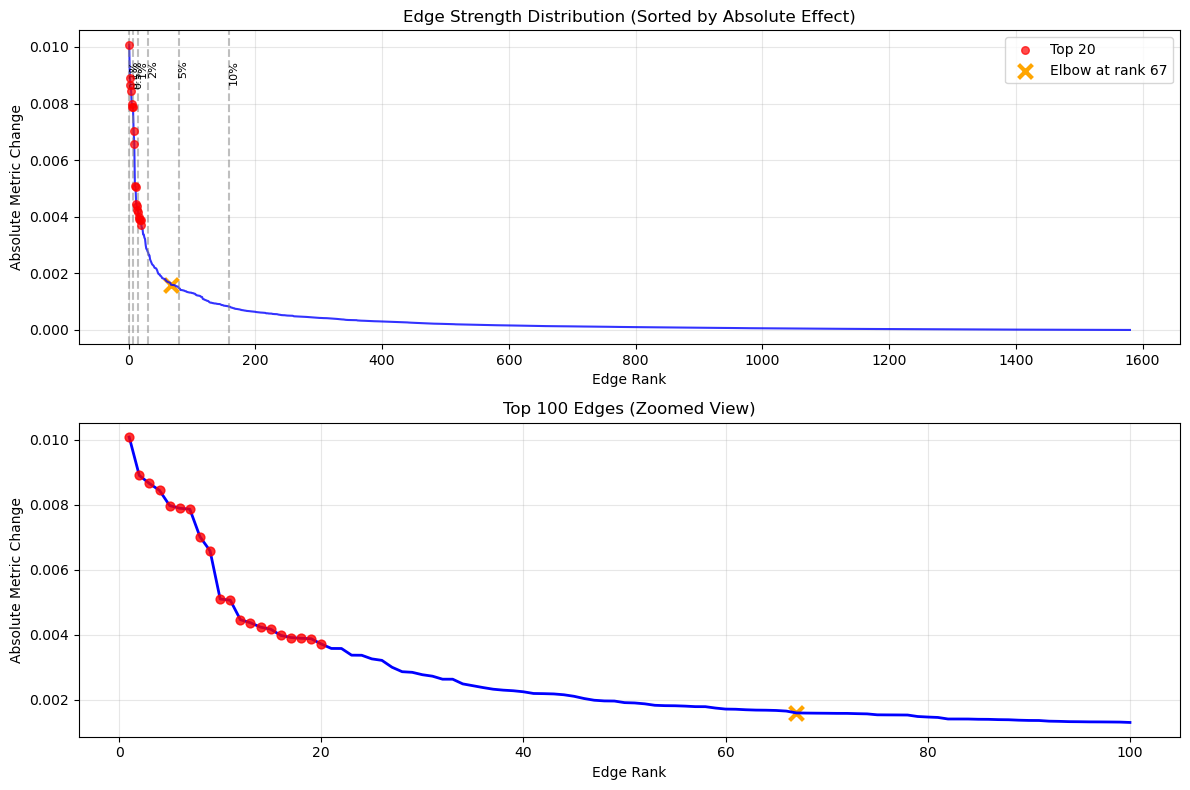


Edge Strength Distribution Statistics:
Total edges: 1580
Strongest edge: 0.010083
Median edge strength: 0.000102
Mean edge strength: 0.000348

Percentile thresholds:
Top  0.1%: 0.010083 (rank 1)
Top  0.5%: 0.007866 (rank 7)
Top  1.0%: 0.004173 (rank 15)
Top  2.0%: 0.002729 (rank 31)
Top  5.0%: 0.001488 (rank 79)
Top 10.0%: 0.000826 (rank 158)


In [ ]:
# Create edge strength distribution plot
print("\n" + "="*80)
print("EDGE STRENGTH DISTRIBUTION ANALYSIS")
print("="*80)

abs_strengths, ranks = plot_edge_strength_distribution(path_patching_results, top_n=None, show_elbow=True)

In [ ]:
# Get threshold suggestions
suggestions = suggest_thresholds(path_patching_results)
print_threshold_suggestions(suggestions)


THRESHOLD SUGGESTIONS

PERCENTILE Method:
Name         Threshold    # Edges    Rank    
---------------------------------------------
top_0.1%     0.010083     1          1       
top_0.5%     0.007866     7          7       
top_1%       0.004173     15         15      
top_2%       0.002729     31         31      
top_5%       0.001488     79         79      
top_10%      0.000826     158        158     

ELBOW Method:
Name         Threshold    # Edges    Rank    
---------------------------------------------
elbow_1      0.001599     67         67      

ZSCORE Method:
Name         Threshold    # Edges    Rank    
---------------------------------------------
z_1.0        0.001176     113        113     
z_1.5        0.001590     69         69      
z_2.0        0.002004     46         46      
z_2.5        0.002418     35         35      
z_3.0        0.002831     29         29      



------------------------------------------------------------
Zoomed view of top 200 edges:


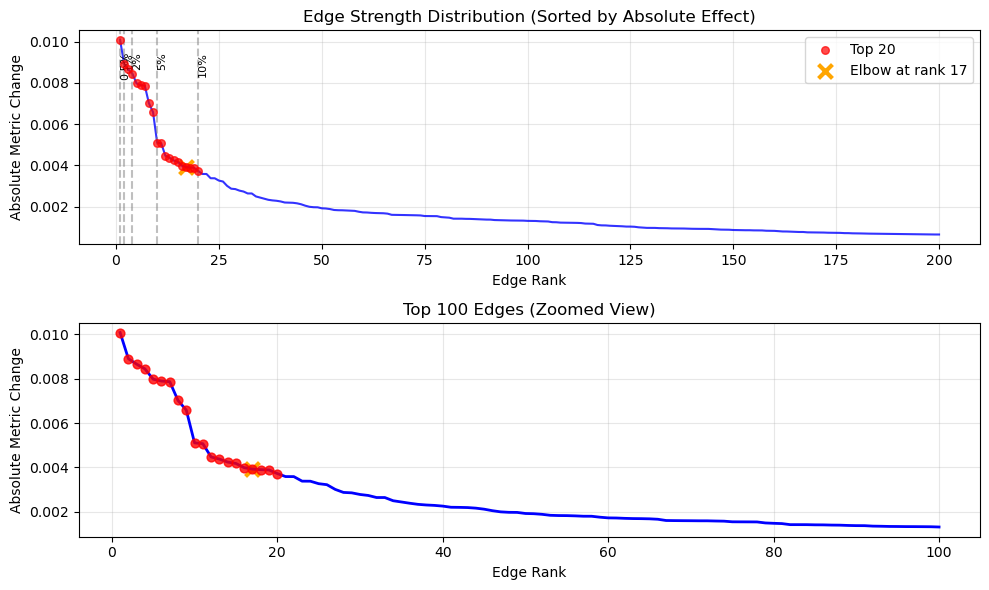


Edge Strength Distribution Statistics:
Total edges: 1580
Strongest edge: 0.010083
Median edge strength: 0.001303
Mean edge strength: 0.001819

Percentile thresholds:
Top  0.5%: 0.010083 (rank 1)
Top  1.0%: 0.008903 (rank 2)
Top  2.0%: 0.008444 (rank 4)
Top  5.0%: 0.005103 (rank 10)
Top 10.0%: 0.003718 (rank 20)


([0.010083377361297607,
  0.008902966976165771,
  0.008656203746795654,
  0.008443772792816162,
  0.007977843284606934,
  0.007893860340118408,
  0.007865607738494873,
  0.007018625736236572,
  0.006583809852600098,
  0.005103349685668945,
  0.00506591796875,
  0.004466533660888672,
  0.004371285438537598,
  0.0042359232902526855,
  0.004173338413238525,
  0.0039827823638916016,
  0.003918290138244629,
  0.0038938522338867188,
  0.003880798816680908,
  0.003718435764312744,
  0.003581702709197998,
  0.0035802125930786133,
  0.003374934196472168,
  0.0033721923828125,
  0.0032608509063720703,
  0.0032150745391845703,
  0.0030034780502319336,
  0.002866387367248535,
  0.0028473734855651855,
  0.0027736425399780273,
  0.002728700637817383,
  0.0026358962059020996,
  0.002635478973388672,
  0.0024912357330322266,
  0.002435147762298584,
  0.0023786425590515137,
  0.002328157424926758,
  0.0022991299629211426,
  0.00228041410446167,
  0.0022485852241516113,
  0.002196371555328369,
  0.00219

In [ ]:
# You can also zoom in on just the top edges
print("\n" + "-"*60)
print("Zoomed view of top 200 edges:")
plot_edge_strength_distribution(path_patching_results, top_n=200, show_elbow=True, figsize=(10, 6))

In [ ]:
def calculate_area_under_curve(abs_strengths, top_percent=10):
    """
    Calculate area under the curve for top X% of edges.
    
    Args:
        abs_strengths: List of absolute strengths (sorted descending)
        top_percent: Percentage of top edges to include
    
    Returns:
        area: Area under the curve for top X% edges
        n_edges: Number of edges included
    """
    
    n_edges = int(len(abs_strengths) * top_percent / 100)
    if n_edges == 0:
        return 0, 0
    
    # Use trapezoidal rule for area calculation
    top_strengths = abs_strengths[:n_edges]
    x_values = list(range(1, len(top_strengths) + 1))
    
    # Calculate area using trapezoidal rule
    area = np.trapz(top_strengths, x_values)
    
    return area, n_edges

def analyze_interpretable_edges(path_patching_results, feature_clusters, top_percent=10):
    """
    Analyze edges between interpretable latents in the top X%.
    
    Args:
        path_patching_results: List of path patching results  
        feature_clusters: Dictionary of interpretable latents
        top_percent: Percentage of top edges to analyze
        
    Returns:
        interpretable_edges: List of edges with interpretable latents
    """
    
    # Sort by absolute strength
    abs_sorted_results = sorted(path_patching_results, key=lambda x: abs(x[4]), reverse=True)
    
    # Get top X%
    n_top = int(len(abs_sorted_results) * top_percent / 100)
    top_edges = abs_sorted_results[:n_top]
    
    print(f"\nAnalyzing top {top_percent}% edges ({n_top} edges)")
    
    # Calculate area under curve
    abs_strengths = [abs(result[4]) for result in abs_sorted_results]
    auc, _ = calculate_area_under_curve(abs_strengths, top_percent)
    total_auc, _ = calculate_area_under_curve(abs_strengths, 100)
    auc_fraction = auc / total_auc if total_auc > 0 else 0
    
    print(f"Area under curve for top {top_percent}%: {auc:.4f}")
    print(f"Fraction of total AUC captured: {auc_fraction:.3f} ({auc_fraction*100:.1f}%)")
    
    # Find interpretable edges
    interpretable_edges = []
    
    for rank, (up_layer, up_latent, down_layer, down_latent, metric_change) in enumerate(top_edges, 1):
        # Check if both upstream and downstream latents are in feature clusters
        up_interpretable = (up_layer in feature_clusters and 
                           up_latent in feature_clusters[up_layer])
        down_interpretable = (down_layer in feature_clusters and 
                             down_latent in feature_clusters[down_layer])
        
        if up_interpretable and down_interpretable:
            up_feature = feature_clusters[up_layer][up_latent]
            down_feature = feature_clusters[down_layer][down_latent]
            
            interpretable_edges.append({
                'rank': rank,
                'up_layer': up_layer,
                'up_latent': up_latent,
                'up_feature': up_feature,
                'down_layer': down_layer,  
                'down_latent': down_latent,
                'down_feature': down_feature,
                'metric_change': metric_change,
                'abs_change': abs(metric_change)
            })
    
    return interpretable_edges

def print_interpretable_edges(interpretable_edges):
    """Print formatted table of interpretable edges"""
    
    if not interpretable_edges:
        print("\nNo edges found with both upstream and downstream latents in feature clusters.")
        return
    
    print(f"\n{'='*100}")
    print(f"INTERPRETABLE EDGES (Both upstream and downstream latents are interpretable)")
    print(f"{'='*100}")
    
    print(f"{'Rank':<6} {'Up Layer':<8} {'Up Latent':<10} {'Up Feature':<15} {'Down Layer':<10} {'Down Latent':<12} {'Down Feature':<15} {'Metric Change':<13}")
    print(f"{'-'*100}")
    
    for edge in interpretable_edges:
        print(f"{edge['rank']:<6} {edge['up_layer']:<8} {edge['up_latent']:<10} {edge['up_feature']:<15} "
              f"{edge['down_layer']:<10} {edge['down_latent']:<12} {edge['down_feature']:<15} {edge['metric_change']:<13.6f}")
    
    print(f"\nFound {len(interpretable_edges)} interpretable edges in the top 10%")
    
    # Group by feature pairs
    feature_pairs = {}
    for edge in interpretable_edges:
        pair = (edge['up_feature'], edge['down_feature'])
        if pair not in feature_pairs:
            feature_pairs[pair] = []
        feature_pairs[pair].append(edge)
    
    print(f"\nFeature pair summary:")
    for (up_feat, down_feat), edges in feature_pairs.items():
        print(f"{up_feat} → {down_feat}: {len(edges)} edges")

In [ ]:
feature_clusters = {
    # Layer 4 clusters
    4: {340: "FX'", 237: "FX'", 3788: "X'XI", 798: "D'XXGN", 1690: "X'XXF", 2277: "G", 2311: "X'XM", 3634: "X'XXXG", 1682: "PXXXXXX'", 3326: "H"}, 
    
    # # Layer 8 clusters  
    8: {488:"AB_Hydrolase_fold", 2677:"FAD/NAD", 2775:"Transketolase", 2166:"DHFR"}, 
    
    # # Layer 12 clusters
    12:  {2112: "AB_Hydrolase_fold", 3536:"SAM_mtases", 1256: "FAM", 2797: "Aldolase", 3794: "SAM_mtases", 3035: "WD40"},
}
# Analyze the top 10% edges and find interpretable ones
print("\n" + "="*80)
print("TOP 10% EDGE ANALYSIS WITH INTERPRETABLE FEATURES")
print("="*80)

interpretable_edges = analyze_interpretable_edges(path_patching_results, feature_clusters, top_percent=10)
print_interpretable_edges(interpretable_edges)


TOP 10% EDGE ANALYSIS WITH INTERPRETABLE FEATURES

Analyzing top 10% edges (158 edges)
Area under curve for top 10%: 0.3284
Fraction of total AUC captured: 0.603 (60.3%)

INTERPRETABLE EDGES (Both upstream and downstream latents are interpretable)
Rank   Up Layer Up Latent  Up Feature      Down Layer Down Latent  Down Feature    Metric Change
----------------------------------------------------------------------------------------------------
19     4        1690       X'XXF           8          2775         Transketolase   -0.003881    
26     4        798        D'XXGN          8          2775         Transketolase   -0.003215    
47     8        2775       Transketolase   12         1256         FAM             -0.001989    
67     8        2775       Transketolase   12         2112         AB_Hydrolase_fold -0.001599    
76     8        2677       FAD/NAD         12         2112         AB_Hydrolase_fold -0.001538    
129    8        2677       FAD/NAD         12         1256      


------------------------------------------------------------
Zoomed view of top 200 edges:


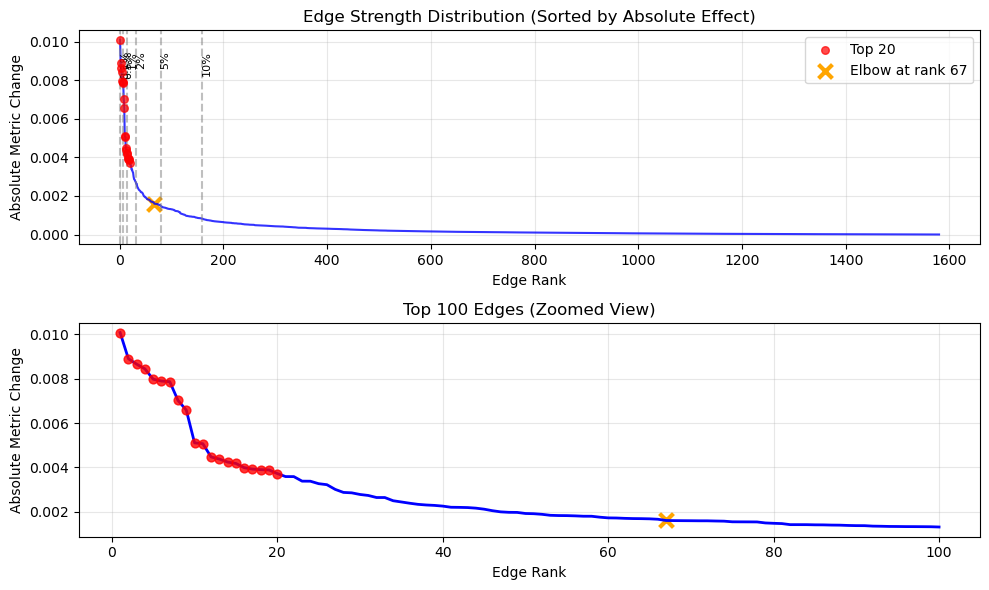


Edge Strength Distribution Statistics:
Total edges: 1580
Strongest edge: 0.010083
Median edge strength: 0.000102
Mean edge strength: 0.000348

Percentile thresholds:
Top  0.1%: 0.010083 (rank 1)
Top  0.5%: 0.007866 (rank 7)
Top  1.0%: 0.004173 (rank 15)
Top  2.0%: 0.002729 (rank 31)
Top  5.0%: 0.001488 (rank 79)
Top 10.0%: 0.000826 (rank 158)


([0.010083377361297607,
  0.008902966976165771,
  0.008656203746795654,
  0.008443772792816162,
  0.007977843284606934,
  0.007893860340118408,
  0.007865607738494873,
  0.007018625736236572,
  0.006583809852600098,
  0.005103349685668945,
  0.00506591796875,
  0.004466533660888672,
  0.004371285438537598,
  0.0042359232902526855,
  0.004173338413238525,
  0.0039827823638916016,
  0.003918290138244629,
  0.0038938522338867188,
  0.003880798816680908,
  0.003718435764312744,
  0.003581702709197998,
  0.0035802125930786133,
  0.003374934196472168,
  0.0033721923828125,
  0.0032608509063720703,
  0.0032150745391845703,
  0.0030034780502319336,
  0.002866387367248535,
  0.0028473734855651855,
  0.0027736425399780273,
  0.002728700637817383,
  0.0026358962059020996,
  0.002635478973388672,
  0.0024912357330322266,
  0.002435147762298584,
  0.0023786425590515137,
  0.002328157424926758,
  0.0022991299629211426,
  0.00228041410446167,
  0.0022485852241516113,
  0.002196371555328369,
  0.00219

In [ ]:
# You can also zoom in on just the top edges
print("\n" + "-"*60)
print("Zoomed view of top 200 edges:")
plot_edge_strength_distribution(path_patching_results, top_n=2000, show_elbow=True, figsize=(10, 6))

In [ ]:
feature_clusters = {
    # Layer 4 clusters
    4: {340: "FX'", 237: "FX'", 3788: "X'XI", 798: "D'XXGN", 1690: "X'XXF", 2277: "G", 2311: "X'XM", 3634: "X'XXXG", 1682: "PXXXXXX'", 3326: "H"}, 
    
    # # Layer 8 clusters  
    8: {488:"AB_Hydrolase_fold", 2677:"FAD/NAD", 2775:"Transketolase", 2166:"DHFR"}, 
    
    # # Layer 12 clusters
    12:  {2112: "AB_Hydrolase_fold", 3536:"SAM_mtases", 1256: "FAM", 2797: "Aldolase", 3794: "SAM_mtases", 3035: "WD40"},
}
# Analyze the top 10% edges and find interpretable ones
print("\n" + "="*80)
print("TOP 10% EDGE ANALYSIS WITH INTERPRETABLE FEATURES")
print("="*80)

interpretable_edges = analyze_interpretable_edges(path_patching_results, feature_clusters, top_percent=20)
print_interpretable_edges(interpretable_edges)


TOP 10% EDGE ANALYSIS WITH INTERPRETABLE FEATURES

Analyzing top 20% edges (316 edges)
Area under curve for top 20%: 0.4172
Fraction of total AUC captured: 0.765 (76.5%)

INTERPRETABLE EDGES (Both upstream and downstream latents are interpretable)
Rank   Up Layer Up Latent  Up Feature      Down Layer Down Latent  Down Feature    Metric Change
----------------------------------------------------------------------------------------------------
19     4        1690       X'XXF           8          2775         Transketolase   -0.003881    
26     4        798        D'XXGN          8          2775         Transketolase   -0.003215    
47     8        2775       Transketolase   12         1256         FAM             -0.001989    
67     8        2775       Transketolase   12         2112         AB_Hydrolase_fold -0.001599    
76     8        2677       FAD/NAD         12         2112         AB_Hydrolase_fold -0.001538    
129    8        2677       FAD/NAD         12         1256      